# **PREPARATION**

## Libraries

In [1]:
#.libPaths("/home/loic/R/x86_64-pc-linux-gnu-library/4.1")

library(Rmisc)    # summarySE
library(car)      # Anova()
library(lme4)     # mixed models
library(lmerTest) # mixed models (p-values)
library(emmeans)  # post-hoc tests
library(correlation) # for multilevel correlations
library(performance) # for check_model() (model diagnostics)
library(sjPlot)   # for tab_model() (table of model estimates)

library(png)      # load png files
library(grid)      # add pictures on plots
library(patchwork) # multiple plots

library(tidyverse) # general data manipulation and visualization

options(readr.num_columns = 0) # suppress readr messages
options(contrasts=c('contr.sum','contr.poly'))
options(jupyter.plot_scale=1)
options(dplyr.summarise.inform = FALSE) # suppress summarise() messages

emm_options(lmer.df = "satterthwaite", # calculate p-values with Satterthwaite's approximation of dof
            lmerTest.limit = 30000,
            emmeans = list(type = "response"), # back-transform estimates to original scale
            contrast = list(infer = c(TRUE, TRUE))) # get CI and p-values systematically in post hoc

Loading required package: lattice

Loading required package: plyr

Loading required package: carData

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘hms’”
Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Loading required package: Matrix

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Install package "strengejacke" from GitHub (`devtools::install_github("strengejacke/strengejacke")`) to load all sj-packages at once!

── Attaching packages ──────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3   

## Custom functions

In [3]:
# Back-transform post hoc contrasts to original scale
emm_backtrans <- function(emm, f) {
    emm  %>% 
        as_tibble() %>% 
        mutate_at(vars("estimate",contains(".CL")), f) %>% 
        mutate(contrast = str_replace(contrast," - "," / "))
}

In [5]:
# Formatting p-values according to guideliness
format.p <- function(x) {
    map_chr(x, .f = function(x) {
        if (!is.numeric(x)) {
            x
        } else if (round(x, 3) == 0) {
            "$<$.001"
        } else if (round(x, 3) == 1) {
            "$>$.99"
        } else if (x >= 0.1) {
            str_replace(format(round(x, 2), digits = 4, nsmall = 2, drop0trailing = F),
                "0\\.", ".")
        } else if (x < 0.1) {
            str_replace(format(round(x, 3), digits = 4, nsmall = 3, drop0trailing = F),
                "0\\.", ".")
        }
    })
}

# Function to ensure values of the same type have the same number of digits
# (e.g. 0.40 and 0.21, and not 0.4 and 0.21 ; useful for tables)

format.digits = function(x, n) {
    if (is.numeric(x)) {
        format(round(x, n), nsmall = n, drop0trailing = F)
    } else {
        x
    }
}

In [6]:
# Function for adding pictures to separate facets
# (see https://stackoverflow.com/questions/44688623/adding-custom-images-to-ggplot-facets)

annotation_custom2 <- function (grob, xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf, data)
{layer(data = data, stat = StatIdentity, position = PositionIdentity, 
       geom = ggplot2:::GeomCustomAnn,
       inherit.aes = TRUE, params = list(grob = grob, 
                                         xmin = xmin, xmax = xmax, 
                                         ymin = ymin, ymax = ymax))}

## Theme

In [7]:
theme_update(text = element_text(family = "Quattrocento Sans"),
             axis.text = element_text(color="black"), # all tick labels in black
             panel.background = element_rect("white"), # white background for plots
             strip.background = element_rect(fill="white"), # white background for facet labels
             strip.text = element_text(size=12), # larger font for facet labels 
             legend.margin=margin(c(0,0,0,-5)), # legend closer to plot
             legend.text.align = 0 # left alignment
            )

aff.colors <- c("low"="chocolate1","high"="chocolate4")

ERROR: Error in theme_update(text = element_text(family = "Quattrocento Sans"), : could not find function "theme_update"


## Data

In [9]:
df.measures <- read_tsv("./BINRIV_measures.csv") %>% 
    mutate(group = factor(group, levels = c("NVM","LTM"))) %>% 
    mutate(state = factor(state, levels = c("BL","OM"))) %>% 
    mutate(aff = factor(aff, levels = c("low","high"))) %>% 
    mutate(percept = factor(percept, levels = c("grating","object","mixed")))

glimpse(df.measures)

Rows: 25075 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): group, state, img, aff, percept
dbl (5): id, run, dur, alpha, mu

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 25,075
Columns: 10
$ group   <fct> LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LT…
$ id      <dbl> 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76…
$ state   <fct> BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL…
$ run     <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ img     <chr> "hammer", "hammer", "hammer", "hammer", "hammer", "hammer", "h…
$ aff     <fct> low, low, low, low, low, low, low, low, low, low, low, low, lo…
$ percept <fct> object, grating, mixed, object, grating, object, mixed, object…
$ dur     <dbl> 5.61300, 3.58970, 0.91792, 2.79280, 3.69510, 1.04680, 1.32020,…
$ alpha   <dbl> 2.55160, 1.73020, NA, 1.18780, 2.12130, NA, NA, 1.31140, NA, 1…
$ mu      <dbl> 1.6893, 1.9897, NA, 1.6153, 2.6921, NA, NA, 2.4088, NA, 2.3506…


In [10]:
df.scales <- read_tsv("./BINRIV_scales.csv") %>% 
    mutate(group = factor(group, levels = c("NVM","LTM"))) %>% 
    mutate(state = factor(state, levels = c("BL","OM"))) %>% 
    mutate(aff = factor(aff, levels = c("low","high")))
glimpse(df.scales)

Rows: 1037 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): group, state, aff
dbl (6): id, run, subjreal, effort, calm, awake

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,037
Columns: 9
$ group    <fct> NVM, NVM, NVM, NVM, NVM, NVM, NVM, NVM, NVM, NVM, NVM, NVM, N…
$ id       <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ state    <fct> BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, B…
$ aff      <fct> low, low, low, low, low, low, low, low, high, high, high, hig…
$ run      <dbl> 17, 19, 23, 24, 25, 28, 31, 32, 18, 20, 21, 22, 26, 27, 29, 3…
$ subjreal <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ effort   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ calm     <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ awake    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…


In [83]:
df.demographics <- read_tsv("./BINRIV_demographics.csv") %>% 
    mutate(group = factor(group, levels = c("NVM","LTM")))

glimpse(df.demographics)

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): group, sex
dbl (4): id, subjidx, age, education

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 33
Columns: 6
$ id        <dbl> 76, 87, 58, 65, 91, 99, 57, 75, 108, 74, 79, 109, 105, 80, 9…
$ subjidx   <dbl> 1, 2, 3, 5, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22…
$ group     <fct> LTM, NVM, LTM, LTM, NVM, NVM, LTM, LTM, NVM, LTM, LTM, NVM, …
$ sex       <chr> "M", "M", "F", "M", "M", "F", "M", "F", "F", "F", "F", "F", …
$ age       <dbl> 54, 51, 55, 39, 54, 62, 58, 50, 40, 57, 63, 53, 48, 53, 50, …
$ education <dbl> 5, 5, 3, 5, 8, 5, 6, 3, 4, 0, 2, 3, 2, 5, 5, 2, 2, 3, 2, 4, …


cols(
  id = col_double(),
  subjidx = col_double(),
  group = col_character(),
  sex = col_character(),
  age = col_double(),
  education = col_double()
)

# **STATISTICS**

## PERCEPT DURATIONS: affordance ratio

### Prepare data

In [12]:
df.dur.ratio <- df.measures %>%
    filter(run == lead(run)) %>% # exclude the last trial of each run
    mutate(log_dur = log(dur)) %>% 
    group_by(group,id,state,percept,aff) %>%
    group_by(run, .add = TRUE) %>%
    summarise(log_dur = mean(log_dur, na.rm=T)) %>%
    spread(key = percept, value = log_dur) %>%
    mutate(log_ratio = object-grating) 

`summarise()` has grouped output by 'group', 'id', 'state', 'percept', 'aff'. You can override using the `.groups` argument.


### Main effect of affordance

#### Model

In [429]:
# The random slope for Run is likely to be too small to be estimated and leads to singular fit. It was removed.
m <- lmer(data = filter(df.dur.ratio, state=="BL"),
          log_ratio ~ aff + run + (1+aff|id),
          control = lmerControl(optimizer="bobyqa"))

summary(m)
anova(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_ratio ~ aff + run + (1 + aff | id)
   Data: filter(df.dur.ratio, state == "BL")
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 808.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1987 -0.6218 -0.0289  0.5203  3.9149 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 0.13193  0.3632        
          aff1        0.01247  0.1117   -0.38
 Residual             0.23564  0.4854        
Number of obs: 504, groups:  id, 33

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)   0.303621   0.098877  89.662422   3.071  0.00283 **
aff1         -0.056052   0.029242  25.464450  -1.917  0.06655 . 
run           0.003555   0.004069 315.611119   0.874  0.38299   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr) aff1  
aff1 -0.

Sum Sq    Mean Sq   NumDF DenDF     F value   Pr(>F)    
aff 0.8657692 0.8657692 1      25.46445 3.6740827 0.06655149
run 0.1798423 0.1798423 1     315.61112 0.7632005 0.38299301

#### Effect size

In [431]:
# In the log scale
emmeans(m, ~ aff) %>% pairs(reverse=T)

# Back-transformed to ratios
emmeans(m, ~ aff) %>% pairs(reverse=T, infer = c(T,F)) %>%
    as_tibble() %>% select(-df) %>% 
    mutate_if(is.numeric,exp) %>% 
    mutate(contrast = str_replace(contrast," - "," / "))

 contrast   estimate     SE   df lower.CL upper.CL t.ratio p.value
 high - low    0.112 0.0585 25.5 -0.00824    0.232   1.917  0.0666

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

contrast   estimate SE       lower.CL  upper.CL
1 high / low 1.118628 1.060229 0.9917965 1.26168

### Interactions

#### Model & diagnostics

In [443]:
# NOTE 1: the default "nloptwrap" optimizer is the only one that does not produce a singular fit for this model
# NOTE 2: a slight convergence issue remains, that disappears when the random effect Run is removed from the model. Although this removal does not impact the other effects significantly, we have chosen to keep all random effects in the model for more precise estimates. 
m.dur.ratio <- lmer(data = df.dur.ratio,
                    log_ratio ~ (group+state+aff)^3 + run + (1+state+aff+run|id))

anova(m.dur.ratio)
summary(m.dur.ratio)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0597039 (tol = 0.002, component 1)”


Sum Sq      Mean Sq     NumDF DenDF     F value   Pr(>F)     
group           0.951881529 0.951881529 1      31.06526 4.3675542 0.044908753
state           0.116362923 0.116362923 1      57.29818 0.5339124 0.467944031
aff             0.337149764 0.337149764 1      21.12582 1.5469571 0.227210210
run             1.726861903 1.726861903 1      27.49974 7.9234261 0.008914445
group:state     0.442637608 0.442637608 1      56.54235 2.0309710 0.159619016
group:aff       0.005714052 0.005714052 1      20.26729 0.0262180 0.872972427
state:aff       0.872689449 0.872689449 1     903.25928 4.0041942 0.045685994
group:state:aff 1.101726616 1.101726616 1     903.17603 5.0550941 0.024794078

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_ratio ~ (group + state + aff)^3 + run + (1 + state + aff +  
    run | id)
   Data: df.dur.ratio

REML criterion at convergence: 1496.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5145 -0.6091 -0.0133  0.5277  4.1776 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr             
 id       (Intercept) 1.577e-01 0.397155                  
          state1      3.545e-04 0.018829  0.66            
          aff1        9.953e-03 0.099766  0.02 -0.49      
          run         8.776e-05 0.009368 -0.50 -0.33 -0.42
 Residual             2.179e-01 0.466845                  
Number of obs: 995, groups:  id, 33

Fixed effects:
                     Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)          0.266126   0.076670  30.795965   3.471  0.00156 **
group1              -0.131051   0.062708  31.065265  -2.090  0.04491 * 
state1              -0.0

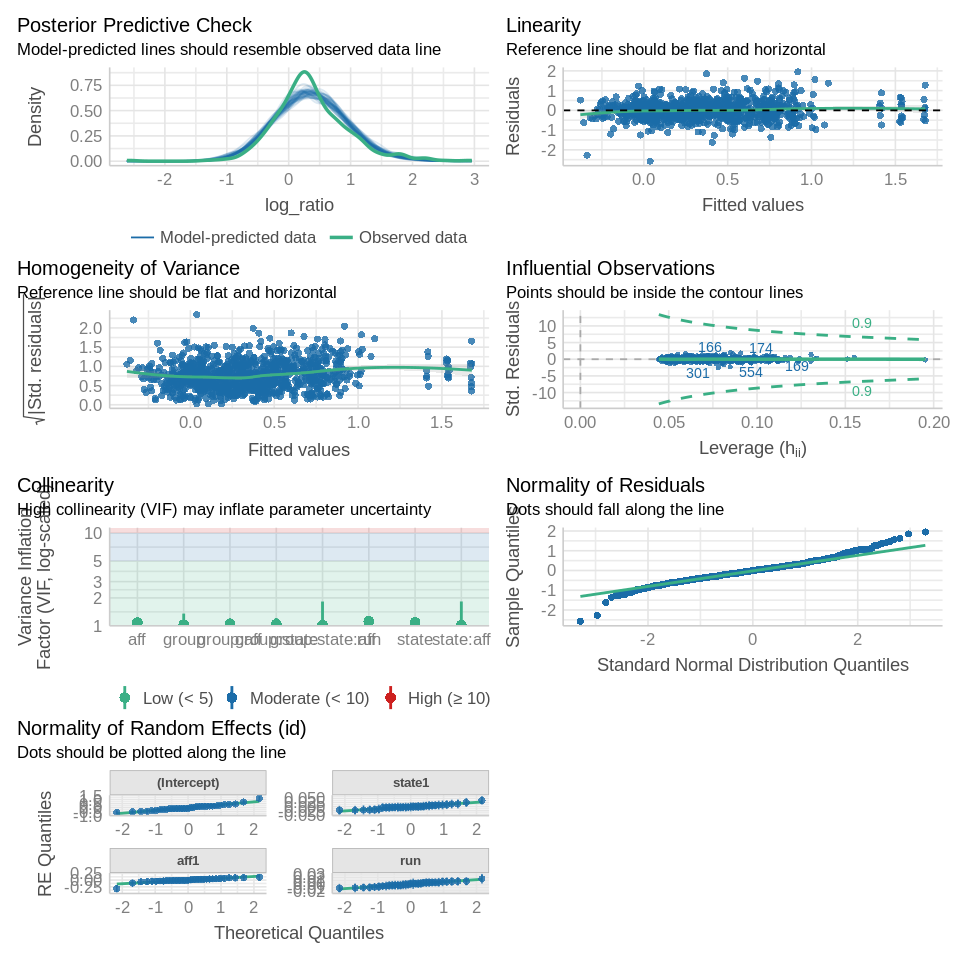

In [16]:
options(repr.plot.width=8, repr.plot.height=8)

check_model(m.dur.ratio)

In [18]:
tab_model(m.dur.ratio,
          transform = "exp",
          show.intercept = F,
          digits = 2,
          dv.labels = "object/grating duration ratio",
          pred.labels = c("Group","State","Affordance","Run",
                          "Group X State", "Group X Affordance", "State X Affordance", "Group X State X Affordance"),
          file="./tab_model_dur_ratio.html")

#### Post hoc tests

In [851]:
# There is a state by affordance interaction for experts but not for novices:
emm <- emmeans(m.dur.ratio, ~ aff*state|group)
contrast(emm, interaction = "revpairwise")

# Same as above but back-transformed to ratios of raw durations:
emmeans(m.dur.ratio, revpairwise ~ aff|state, at=list(group="LTM"))$contrasts %>% emm_backtrans(exp)

group = NVM:
 aff_revpairwise state_revpairwise estimate     SE  df lower.CL upper.CL
 high - low      OM - BL             0.0149 0.0797 915   -0.142   0.1713
 t.ratio p.value
   0.187  0.8518

group = LTM:
 aff_revpairwise state_revpairwise estimate     SE  df lower.CL upper.CL
 high - low      OM - BL            -0.2559 0.0903 892   -0.433  -0.0787
 t.ratio p.value
  -2.835  0.0047

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

NOTE: Results may be misleading due to involvement in interactions



contrast   state estimate  SE         df       lower.CL upper.CL t.ratio   
1 high / low BL    1.1951140 0.08201218 41.61078 1.012769 1.410289  2.1733552
2 high / low OM    0.9252928 0.08319768 43.75226 0.782434 1.094235 -0.9332594
  p.value   
1 0.03549651
2 0.35580805

#### Temporal trend

In [20]:
# Slope
emtrends(m.dur.ratio, ~ 1, var = "run")

# Contrast between beginning and end of the experiment
emmeans(m.dur.ratio, revpairwise ~ run, at=list(run=c(1,32)))

# Same as above, but back-transformed in the original scale
emmeans(m.dur.ratio, ~ run, at=list(run=c(1,32))) %>% 
    as_tibble() %>% 
    mutate_at(vars("emmean",contains(".CL")), exp)

 1       run.trend      SE   df lower.CL upper.CL
 overall   0.00667 0.00237 27.5  0.00181   0.0115

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$emmeans
 run emmean     SE   df lower.CL upper.CL
   1  0.273 0.0753 30.8    0.119    0.426
  32  0.480 0.0703 30.6    0.336    0.623

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$contrasts
 contrast     estimate     SE   df lower.CL upper.CL t.ratio p.value
 run32 - run1    0.207 0.0735 27.5   0.0562    0.358   2.815  0.0089

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 


run emmean   SE         df       lower.CL upper.CL
1  1  1.313637 0.07533093 30.81735 1.126510 1.531849
2 32  1.615592 0.07029169 30.62730 1.399717 1.864761

## MU RHYTHM

### Prepare data

In [739]:
df.mu <- df.measures %>%
    mutate(run = as.integer(run),
           id = as.factor(id)) %>%
    mutate_if(is.double,log) %>% 
    rename_if(is.double, .funs = ~ paste0("log_",.)) %>% 
    create_run.state()

### Main effect of affordance

#### Model

In [863]:
m <- lmer(data = filter(df.mu, state=="BL"),
          log_mu ~ aff + percept + run + (1+aff|id) + (0+percept|id) + (0+run|id),
          control = lmerControl(optimizer="bobyqa"))

AIC(m)
anova(m)
summary(m)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”


[1] 6218.299

Sum Sq    Mean Sq   NumDF DenDF    F value   Pr(>F)      
aff     0.1680655 0.1680655 1     34.89494  1.474031 0.2328639161
percept 2.3068307 1.1534154 2     32.56104 10.116115 0.0003828597
run     1.1823764 1.1823764 1     32.11783 10.370120 0.0029287675

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_mu ~ aff + percept + run + (1 + aff | id) + (0 + percept |  
    id) + (0 + run | id)
   Data: filter(df.mu, state == "BL")
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 6186.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6101 -0.5216  0.0196  0.5721  4.6219 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr      
 id       (Intercept)    3.281e-01 0.572832           
          aff1           4.144e-05 0.006437 -0.10     
 id.1     perceptgrating 2.464e-02 0.156976           
          perceptobject  1.665e-02 0.129030 0.94      
          perceptmixed   5.186e-02 0.227738 0.93  1.00
 id.2     run            7.867e-05 0.008869           
 Residual                1.140e-01 0.337665           
Number of obs: 8718, groups:  id, 33

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  0.66

Could not compute standard errors from random effects for diagnostic plot.


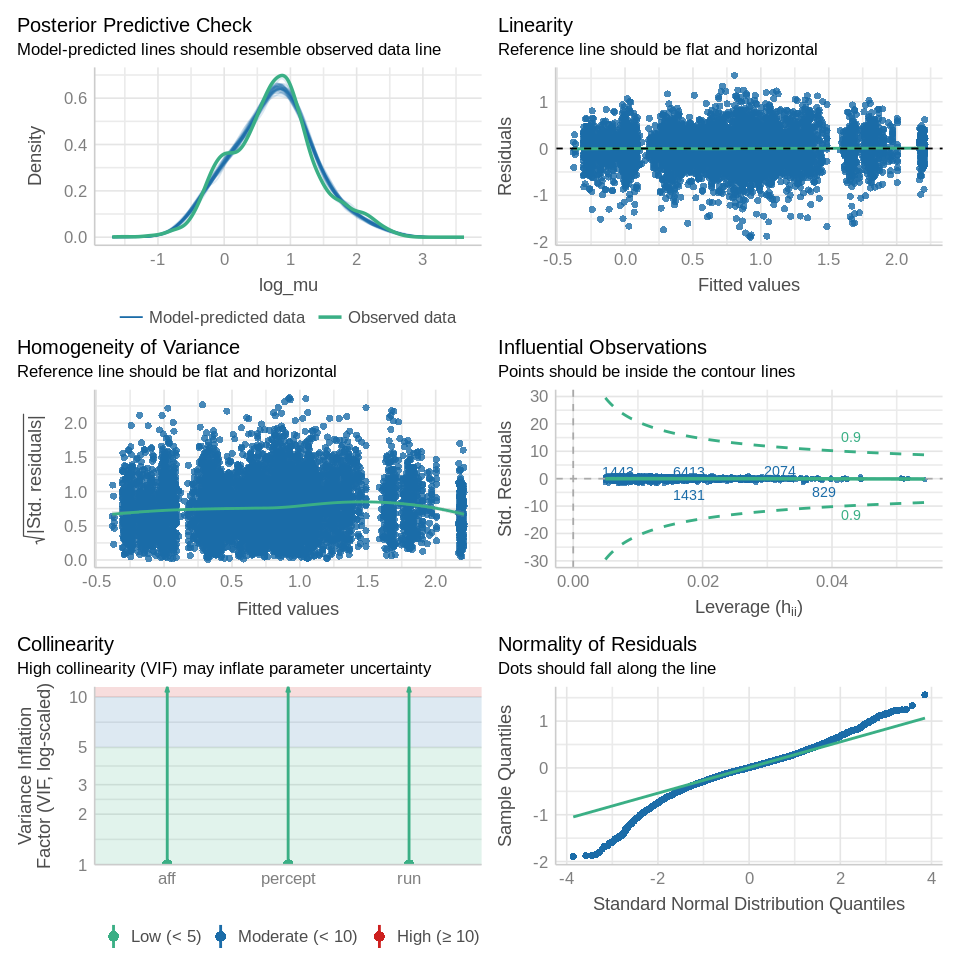

In [864]:
options(repr.plot.width=8, repr.plot.height=8)

check_model(m) # may take a few seconds

#### Effect size

In [865]:
# In the log scale
emmeans(m, ~ aff) %>% pairs(reverse=T)

# Back-transformed to ratios
emmeans(m, ~ aff) %>% pairs(reverse=T)  %>% emm_backtrans(exp)

 contrast   estimate      SE   df lower.CL upper.CL t.ratio p.value
 high - low  0.00948 0.00781 34.9 -0.00638   0.0253   1.214  0.2329

Results are averaged over the levels of: percept 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

contrast   estimate SE          df       lower.CL  upper.CL t.ratio 
1 high / low 1.009529 0.007811436 34.89494 0.9936444 1.025667 1.214097
  p.value  
1 0.2328639

In [866]:
# In the log scale
emmeans(m, ~ percept) %>% pairs(reverse=T)

# Back-transformed to ratios
emmeans(m, ~ percept) %>% pairs(reverse=T) %>% emm_backtrans(exp)

 contrast         estimate     SE   df lower.CL upper.CL t.ratio p.value
 object - grating   0.0420 0.0132 31.9  0.00954   0.0744   3.181  0.0089
 mixed - grating   -0.0399 0.0213 33.9 -0.09216   0.0123  -1.874  0.1618
 mixed - object    -0.0819 0.0208 30.1 -0.13315  -0.0306  -3.938  0.0013

Results are averaged over the levels of: aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Conf-level adjustment: tukey method for comparing a family of 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 

contrast         estimate  SE         df       lower.CL  upper.CL  t.ratio  
1 object / grating 1.0428512 0.01318937 31.85614 1.0095859 1.0772125  3.181236
2 mixed / grating  0.9608558 0.02131106 33.91487 0.9119608 1.0123723 -1.873719
3 mixed / object   0.9213738 0.02079520 30.09649 0.8753366 0.9698323 -3.937900
  p.value    
1 0.008904625
2 0.161835376
3 0.001275027

### Interactions

#### Model & diagnostics

In [753]:
m.mu <- lmer(data = df.mu,
             log_mu ~ (group+state+aff)^3 + percept + run + (1+state+aff+percept|id) + (0+run|id),
             control = lmerControl(optimizer="bobyqa"),
             contrasts=list(group=c(-0.5,0.5),state=c(-0.5,0.5),aff=c(-0.5,0.5)))

AIC(m.mu)
anova(m.mu)
summary(m.mu)

[1] 11546.34

Sum Sq       Mean Sq      NumDF DenDF       F value     
group           1.629702e-02 1.629702e-02 1        30.91809 1.461756e-01
state           7.517990e-03 7.517990e-03 1        23.18668 6.743236e-02
aff             5.427658e-02 5.427658e-02 1        35.54672 4.868319e-01
percept         1.569830e+00 7.849150e-01 2        29.42604 7.040269e+00
run             3.133821e+00 3.133821e+00 1        29.14832 2.810870e+01
group:state     1.162507e-07 1.162507e-07 1        22.95484 1.042707e-06
group:aff       3.683758e-02 3.683758e-02 1        34.09316 3.304134e-01
state:aff       1.090646e+00 1.090646e+00 1     16130.96726 9.782508e+00
group:state:aff 3.270257e-01 3.270257e-01 1     16128.17164 2.933246e+00
                Pr(>F)      
group           7.048329e-01
state           7.974045e-01
aff             4.898830e-01
percept         3.172411e-03
run             1.080342e-05
group:state     9.991941e-01
group:aff       5.691899e-01
state:aff       1.764932e-03
group:state:aff 8.679210e-02

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_mu ~ (group + state + aff)^3 + percept + run + (1 + state +  
    aff + percept | id) + (0 + run | id)
   Data: df.mu
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 11490.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.3277 -0.5140  0.0233  0.5603  4.5559 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr                   
 id       (Intercept) 3.043e-01 0.551672                        
          state1      1.111e-03 0.033331 -0.01                  
          aff1        2.292e-04 0.015140  0.04  0.14            
          percept1    1.437e-03 0.037904  0.01 -0.67 -0.70      
          percept2    2.299e-03 0.047949 -0.01 -0.39  0.29  0.09
 id.1     run         2.384e-05 0.004882                        
 Residual             1.115e-01 0.333900                        
Number of obs: 17043, groups:  id, 33

Fixed effects:
       

Could not compute standard errors from random effects for diagnostic plot.


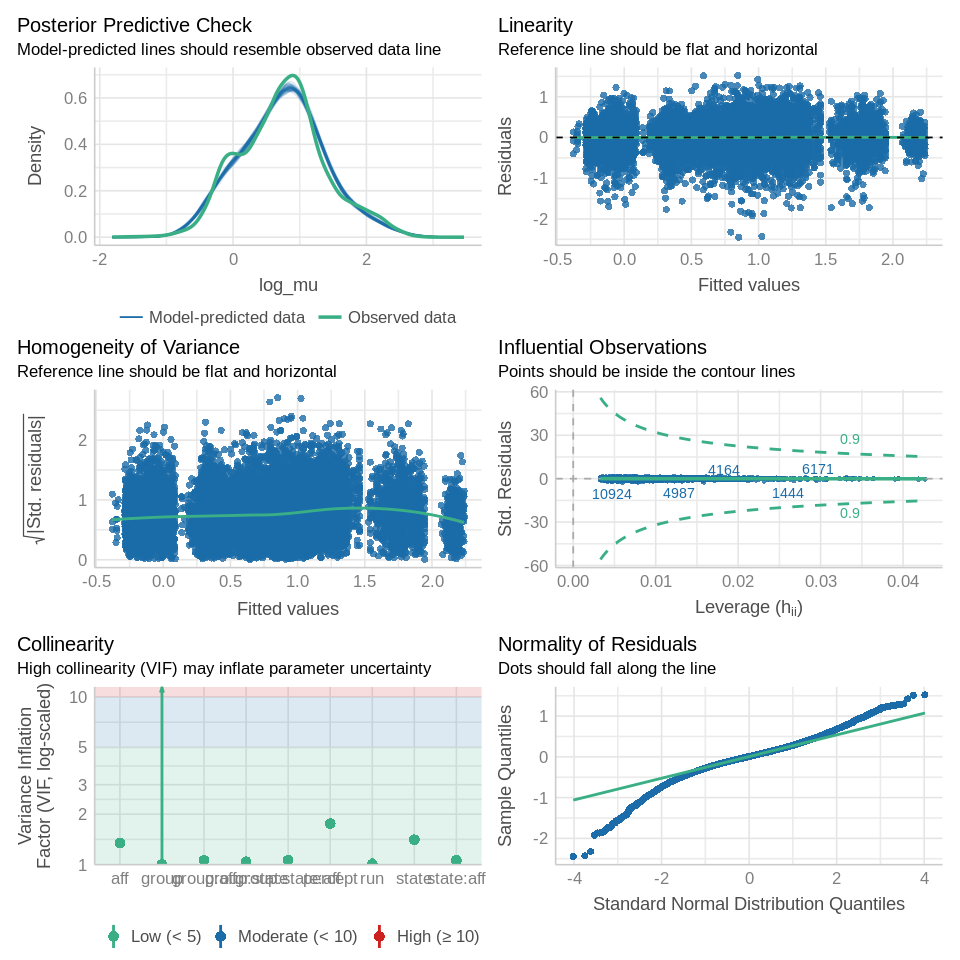

In [758]:
options(repr.plot.width=8, repr.plot.height=8)

check_model(m.mu) # may take a minute

In [ ]:
tab_model(m.mu,
          transform = "exp",
          show.intercept = F,
          digits = 2,
          dv.labels = "µ power",
          pred.labels = c("Group","State","Affordance","Run",
                          "Group X State", "Group X Affordance", "State X Affordance", "Group X State X Affordance"),
          file="./tab_model_mu.html")

#### Post hoc tests

In [868]:
# There is a difference in mu power in OM but not during baseline:
emmeans(m.mu, revpairwise ~ aff|state)$contrasts

# Same as above but back-transformed to ratios of raw durations:
emmeans(m.mu, revpairwise ~ aff|state)$contrasts %>% emm_backtrans(exp)

NOTE: Results may be misleading due to involvement in interactions



state = BL:
 contrast   estimate      SE   df lower.CL upper.CL t.ratio p.value
 high - low   0.0115 0.00916 75.3 -0.00678  0.02972   1.252  0.2145

state = OM:
 contrast   estimate      SE   df lower.CL upper.CL t.ratio p.value
 high - low  -0.0221 0.00943 83.4 -0.04081 -0.00332  -2.341  0.0216

Results are averaged over the levels of: group, percept 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

NOTE: Results may be misleading due to involvement in interactions



contrast   state estimate  SE          df       lower.CL  upper.CL  t.ratio  
1 high / low BL    1.0115345 0.009160818 75.29635 0.9932433 1.0301625  1.251905
2 high / low OM    0.9781768 0.009427267 83.42066 0.9600078 0.9966897 -2.340533
  p.value   
1 0.21447934
2 0.02164378

In [867]:
# In the log scale
emmeans(m.mu, ~ percept) %>% pairs(reverse=T)

# Back-transformed to ratios
emmeans(m.mu, ~ percept) %>% pairs(reverse=T) %>% emm_backtrans(exp)

 contrast         estimate     SE   df  lower.CL upper.CL t.ratio p.value
 object - grating   0.0297 0.0119 30.5  0.000426  0.05900   2.499  0.0462
 mixed - grating   -0.0435 0.0184 28.4 -0.088987  0.00193  -2.368  0.0626
 mixed - object    -0.0732 0.0203 29.6 -0.123197 -0.02329  -3.617  0.0031

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Conf-level adjustment: tukey method for comparing a family of 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 

contrast         estimate  SE         df       lower.CL  upper.CL t.ratio  
1 object / grating 1.0301603 0.01188988 30.47631 1.0004263 1.060778  2.499139
2 mixed / grating  0.9574054 0.01838543 28.37333 0.9148571 1.001932 -2.367549
3 mixed / object   0.9293751 0.02025073 29.65129 0.8840898 0.976980 -3.616802
  p.value    
1 0.046207787
2 0.062592557
3 0.003051666

#### Temporal trend

In [41]:
# Slope
emtrends(m.mu, ~ 1, var = "run")

# Contrast between beginning and end of the experiment
emmeans(m.mu, revpairwise ~ run, at=list(run=c(1,32)))

# Same as above, but back-transformed in the original scale
emmeans(m.mu, ~ run, at=list(run=c(1,32))) %>% 
    as_tibble() %>% 
    mutate_at(vars("emmean",contains(".CL")), exp)

 1       run.trend       SE   df lower.CL upper.CL
 overall   0.00511 0.000947 28.2  0.00317  0.00705

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$emmeans
 run emmean    SE   df lower.CL upper.CL
   1  0.680 0.098 30.9    0.480     0.88
  32  0.838 0.108 30.6    0.619     1.06

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$contrasts
 contrast     estimate     SE   df lower.CL upper.CL t.ratio p.value
 run32 - run1    0.158 0.0294 28.2   0.0982    0.218   5.394  <.0001

Results are averaged over the levels of: group, state, aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 


run emmean   SE         df       lower.CL upper.CL
1  1  1.974136 0.09803832 30.86286 1.616308 2.411182
2 32  2.312820 0.10755235 30.64427 1.857088 2.880389

## SUBJECTIVE REALISM

In [61]:
df.measures %>% select(group,id) %>% distinct() %>% group_by(group) %>% count()

df.scales %>% filter(!is.na(subjreal)) %>% select(group,id) %>% distinct() %>% group_by(group) %>% count()

group n 
1 NVM   19
2 LTM   14

group n 
1 NVM   17
2 LTM    9

### Main effect of affordance

Chisq    Df Pr(>Chisq)
aff 4.772620 1  0.02891579
run 2.670078 1  0.10225101

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: subjreal ~ aff + run + (1 | id)
   Data: df.scales %>% filter(state == "BL")
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
   911.3    927.0   -451.7    903.3      368 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6643 -0.2672 -0.1946  0.1695  4.7767 

Random effects:
 Groups Name        Variance Std.Dev.
 id     (Intercept) 3.698    1.923   
Number of obs: 372, groups:  id, 25

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.721738   0.433357  -1.665   0.0958 .
aff1        -0.084829   0.038830  -2.185   0.0289 *
run          0.013228   0.008096   1.634   0.1023  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr) aff1  
aff1  0.002       
run  -0.339  0.021

No overdispersion detected.



# Overdispersion test

       dispersion ratio =   0.390
  Pearson's Chi-Squared = 143.657
                p-value =       1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 139
  Predicted zeros: 155
            Ratio: 1.12


 contrast   ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value
 high / low  1.18 0.092 Inf      1.02      1.38    1   2.185  0.0289

Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

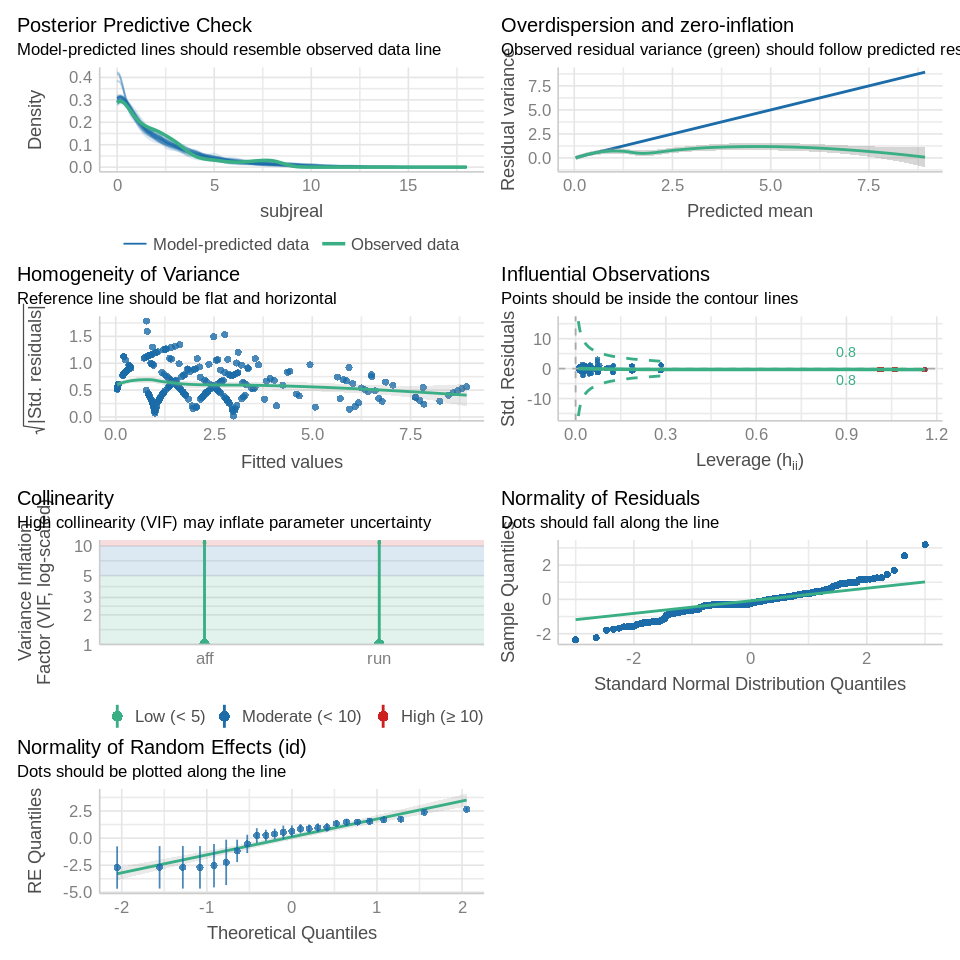

In [62]:
m <- glmer(data = df.scales %>% filter(state=="BL"),
           subjreal ~ aff + run + (1|id),
           family = poisson, control = glmerControl(optimizer="bobyqa"))

Anova(m)
summary(m)

# Diagnostics
check_overdispersion(m)
check_zeroinflation(m) # the zero-inflation ratio (1.12) is rather low

options(repr.plot.width=8, repr.plot.height=8)
check_model(m)

# Effect size
emmeans(m, revpairwise ~ aff)$contrasts

### Interactions

#### Model & effects

Chisq        Df Pr(>Chisq)
group           4.7211500760 1  0.02979381
state           0.5927606132 1  0.44135359
aff             4.1210460958 1  0.04235288
run             2.1188145676 1  0.14549912
group:state     0.0597724729 1  0.80685592
group:aff       0.0007119602 1  0.97871290
state:aff       0.0065626372 1  0.93543392
group:state:aff 0.4085344390 1  0.52271431

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: subjreal ~ group * state * aff + run + (1 + state + aff | id) +  
    (0 + run | id)
   Data: df.scales
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  1868.9   1943.4   -918.5   1836.9      758 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6164 -0.3117 -0.1301  0.1313  4.5731 

Random effects:
 Groups Name        Variance  Std.Dev. Corr       
 id     (Intercept) 4.1796572 2.04442             
        state1      0.0410606 0.20263  -0.70      
        aff1        0.0102285 0.10114   0.63 -0.64
 id.1   run         0.0001303 0.01142             
Number of obs: 774, groups:  id, 26

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)  
(Intercept)        -0.9828617  0.4593218  -2.140   0.0324 *
group1              0.8293392  0.4477211   1.852   0.0640 .
state1              0.04

No overdispersion detected.



# Overdispersion test

       dispersion ratio =   0.426
  Pearson's Chi-Squared = 323.073
                p-value =       1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 303
  Predicted zeros: 329
            Ratio: 1.09


Could not compute standard errors from random effects for diagnostic plot.


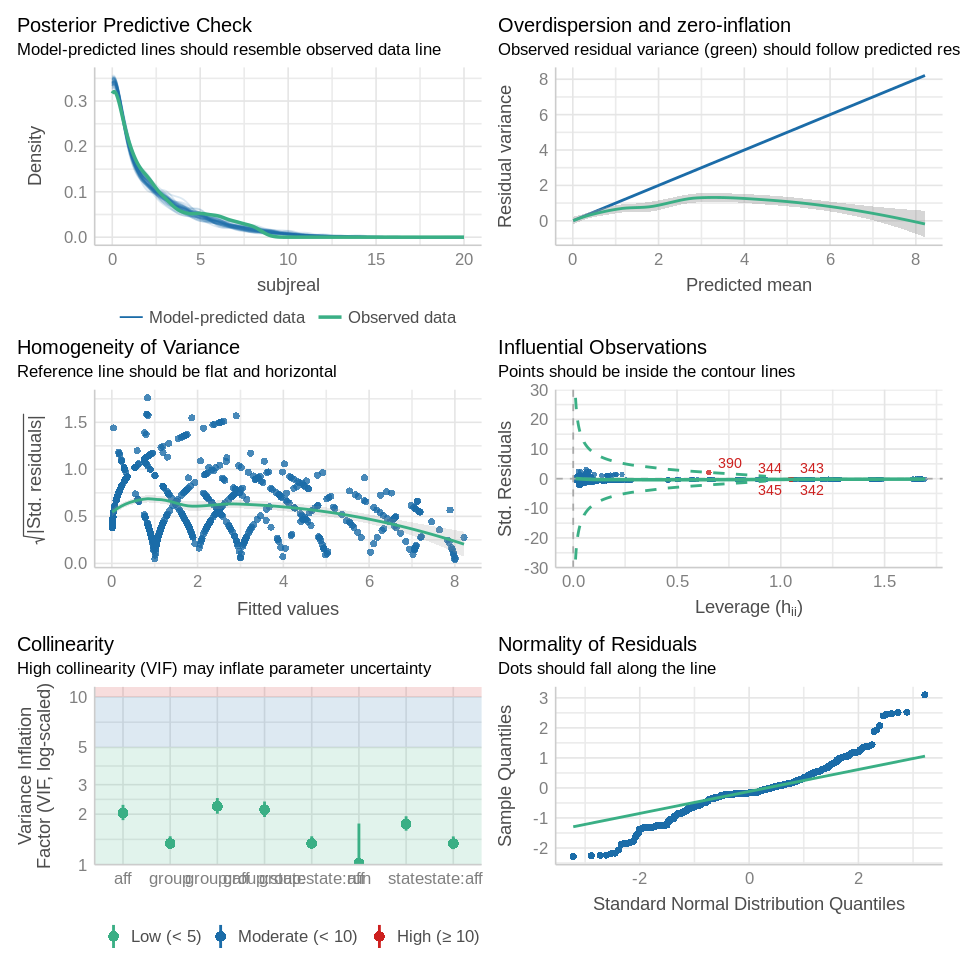

In [63]:
m.subjreal <- glmer(data = df.scales,
                          subjreal ~ group*state*aff + run + (1+state+aff|id) + (0+run|id),
                          family = poisson, control = glmerControl(optimizer="bobyqa"))

Anova(m.subjreal)
summary(m.subjreal)

# Diagnostics
check_overdispersion(m.subjreal)
check_zeroinflation(m.subjreal) # the zero-inflation ratio (1.09) is rather low

options(repr.plot.width=8, repr.plot.height=8)
check_model(m.subjreal)

#### Temporal trend

In [65]:
# Slope
emtrends(m.subjreal, ~ 1, var = "run")

# Contrast between beginning and end of the experiment
emmeans(m.subjreal, revpairwise ~ run, at=list(run=c(1,32)))$contrast


 1       run.trend      SE  df asymp.LCL asymp.UCL
 overall   0.00811 0.00557 Inf  -0.00281     0.019

Results are averaged over the levels of: group, state, aff 
Confidence level used: 0.95 

 contrast     ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value
 run32 / run1  1.29 0.222 Inf     0.917       1.8    1   1.456  0.1455

Results are averaged over the levels of: group, state, aff 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

## PERCEPT DURATIONS: raw

### Model & diagnostics

In [871]:
# May take a few minutes
m.dur <- lmer(data = df.measures %>% filter(run == lead(run)) %>% mutate(log_dur = log(dur)),
              log_dur ~ group*state*aff*percept + run + (1+state+aff+percept+run|id),
              control = lmerControl(optimizer="bobyqa"))

Warning message in optwrap(optimizer, devfun, getStart(start, rho$pp), lower = rho$lower, :
“convergence code 1 from bobyqa: bobyqa -- maximum number of function evaluations exceeded”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00266369 (tol = 0.002, component 1)”


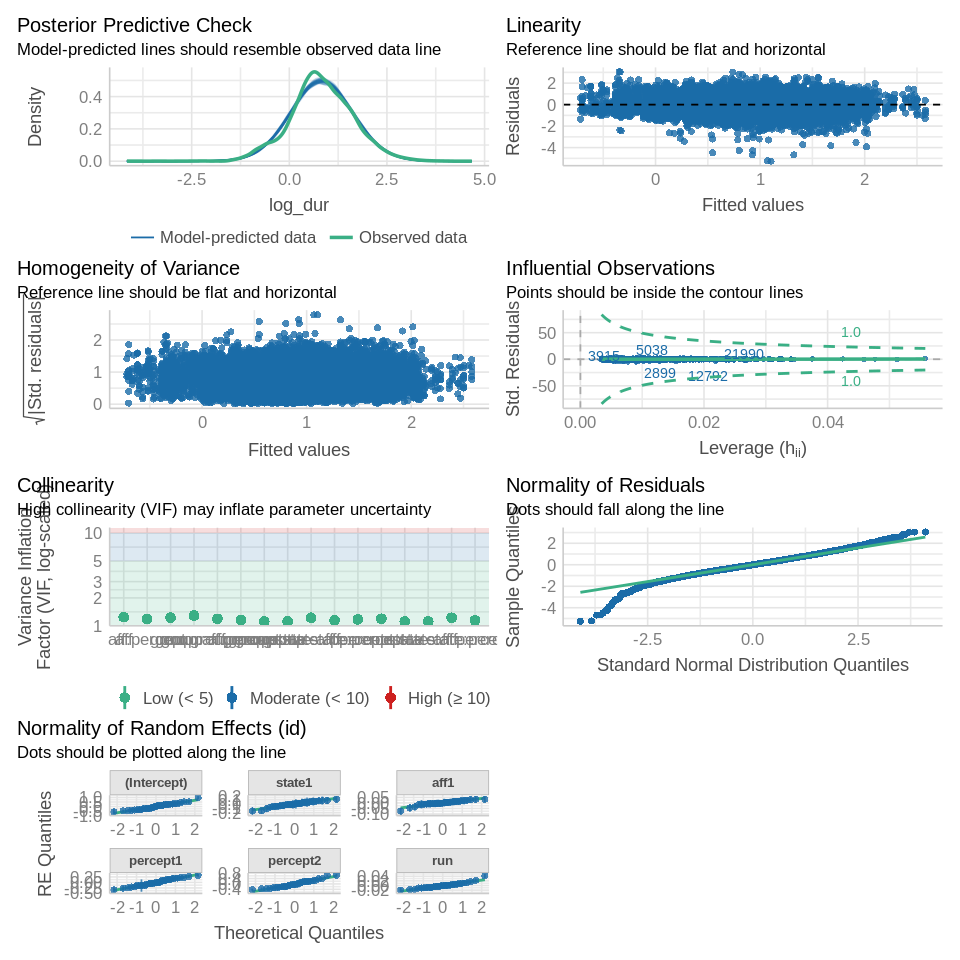

In [872]:
options(repr.plot.width=8, repr.plot.height=8)

check_model(m.dur) # may take a minute

### Testing interactions

In [873]:
anova(m.dur)
summary(m.dur)

Sum Sq       Mean Sq     NumDF DenDF       F value    
group                    0.914970462 0.914970462 1        30.26330  2.01146814
state                    4.413152006 4.413152006 1        28.39490  9.70185927
aff                      0.061513503 0.061513503 1        29.18380  0.13523109
percept                 19.846175231 9.923087616 2        30.20511 21.81488411
run                      4.470801173 4.470801173 1        30.11107  9.82859502
group:state              0.007033142 0.007033142 1        26.45163  0.01546164
group:aff                1.817254163 1.817254163 1        29.13694  3.99504575
state:aff                0.476832055 0.476832055 1     21847.07831  1.04826607
group:percept            4.540148969 2.270074485 2        30.28308  4.99052449
state:percept           18.933602911 9.466801456 2     23649.92830 20.81178608
aff:percept              0.093354764 0.046677382 2     17164.10717  0.10261541
group:state:aff          0.155085112 0.155085112 1     21872.11192  0.34093862
group:state:percept      8.892565465 4.446282732 2     23648.59693  9.77469375
group:aff:percept        0.371473545 0.185736773 2     17161.97196  0.40832313
state:aff:percept        3.527880768 1.763940384 2     23848.46870  3.87784090
group:state:aff:percept  6.440234463 3.220117231 2     23847.90298  7.07909543
                        Pr(>F)      
group                   1.663303e-01
state                   4.180347e-03
aff                     7.157224e-01
percept                 1.372376e-06
run                     3.816843e-03
group:state             9.019824e-01
group:aff               5.503993e-02
state:aff               3.059181e-01
group:percept           1.338798e-02
state:percept           9.321818e-10
aff:percept             9.024745e-01
group:state:aff         5.592940e-01
group:state:percept     5.710289e-05
group:aff:percept       6.647705e-01
state:aff:percept       2.070851e-02
group:state:aff:percept 8.443066e-04


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_dur ~ group * state * aff * percept + run + (1 + state +  
    aff + percept + run | id)
   Data: 
df.measures %>% filter(run == lead(run)) %>% mutate(log_dur = log(dur))
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 49995.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8038 -0.6204 -0.0060  0.6344  4.5198 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr                         
 id       (Intercept) 0.1349132 0.36731                               
          state1      0.0059634 0.07722   0.07                        
          aff1        0.0007285 0.02699  -0.16 -0.30                  
          percept1    0.0312073 0.17666  -0.21 -0.16  0.21            
          percept2    0.0805054 0.28373   0.14 -0.02  0.21  0.10      
          run         0.0001668 0.01292  -0.55 -0.08 -0.43 -0.05 -0.30
 Residual             0.4548769

#### Sub-model for RS

In [874]:
m.dur.RS <- lmer(data = df.measures %>% filter(run==lead(run), state=="BL"),
                 log(dur) ~ group*aff*percept + run + (1+aff+percept+run|id))

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0318052 (tol = 0.002, component 1)”


In [875]:
anova(m.dur.RS)
emmeans(m.dur.RS, pairwise ~ group|percept)$contrast
emmeans(m.dur.RS, pairwise ~ percept|group)$contrast

Sum Sq     Mean Sq    NumDF DenDF       F value   
group              1.0292786  1.0292786 1        30.09771  2.2278623
aff                0.1993388  0.1993388 1        30.80708  0.4314667
percept           21.6003189 10.8001594 2        29.93140 23.3768271
run                1.8427551  1.8427551 1        31.23570  3.9886232
group:aff          0.6082590  0.6082590 1        30.67362  1.3165700
group:percept      3.8007860  1.9003930 2        29.87362  4.1133798
aff:percept        2.0667346  1.0333673 2     11612.80633  2.2367123
group:aff:percept  2.2900076  1.1450038 2     11610.94773  2.4783482
                  Pr(>F)      
group             1.459504e-01
aff               5.161475e-01
percept           7.678197e-07
run               5.458371e-02
group:aff         2.600797e-01
group:percept     2.642736e-02
aff:percept       1.068551e-01
group:aff:percept 8.392604e-02

NOTE: Results may be misleading due to involvement in interactions



percept = grating:
 contrast  ratio    SE   df lower.CL upper.CL null t.ratio p.value
 NVM / LTM 0.988 0.115 28.7    0.779     1.25    1  -0.104  0.9182

percept = object:
 contrast  ratio    SE   df lower.CL upper.CL null t.ratio p.value
 NVM / LTM 0.831 0.127 30.1    0.609     1.14    1  -1.210  0.2359

percept = mixed:
 contrast  ratio    SE   df lower.CL upper.CL null t.ratio p.value
 NVM / LTM 0.698 0.137 29.6    0.468     1.04    1  -1.837  0.0762

Results are averaged over the levels of: aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

NOTE: Results may be misleading due to involvement in interactions



group = NVM:
 contrast         ratio     SE   df lower.CL upper.CL null t.ratio p.value
 grating / object 0.761 0.0575 29.1    0.631    0.917    1  -3.618  0.0031
 grating / mixed  1.643 0.1762 30.7    1.262    2.139    1   4.631  0.0002
 object / mixed   2.160 0.3060 31.3    1.524    3.060    1   5.436  <.0001

group = LTM:
 contrast         ratio     SE   df lower.CL upper.CL null t.ratio p.value
 grating / object 0.640 0.0568 30.2    0.514    0.797    1  -5.025  0.0001
 grating / mixed  1.161 0.1413 30.6    0.860    1.567    1   1.225  0.4476
 object / mixed   1.814 0.2950 30.4    1.215    2.707    1   3.659  0.0027

Results are averaged over the levels of: aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Conf-level adjustment: tukey method for comparing a family of 3 estimates 
Intervals are back-transformed from the log scale 
P value adjustment: tukey method for comparing a family of 3 estimates 
Tests are performed on the log scale 

#### Sub-model for OM

In [878]:
m.dur.OM <- lmer(data = df.measures %>% filter(run==lead(run), state=="OM"),
                 log(dur) ~ group*aff*percept + run + (1+aff+percept+run|id))

anova(m.dur.OM)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.103826 (tol = 0.002, component 1)”


Sum Sq      Mean Sq    NumDF DenDF      F value    
group              0.64886519 0.64886519 1       29.40924  1.50693407
aff                0.03429557 0.03429557 1       30.35529  0.07964853
percept           16.49384921 8.24692460 2       30.36053 19.15277913
run                5.51814405 5.51814405 1       29.04381 12.81541899
group:aff          2.87539775 2.87539775 1       26.62689  6.67786608
group:percept      2.98916948 1.49458474 2       30.29068  3.47104561
aff:percept        1.05113913 0.52556956 2     6226.70600  1.22059049
group:aff:percept  4.37943630 2.18971815 2     6234.55365  5.08543367
                  Pr(>F)      
group             2.293430e-01
aff               7.796896e-01
percept           4.164990e-06
run               1.233077e-03
group:aff         1.557889e-02
group:percept     4.392685e-02
aff:percept       2.951265e-01
group:aff:percept 6.211890e-03

In [885]:
emmeans(m.dur.OM, pairwise ~ aff|percept*group)$contrast # afforfance effect for gratings in LTM but not NVM
emmeans(m.dur.OM, pairwise ~ percept|group)$contrast # no difference between gratings and mixed in LTM

percept = grating, group = NVM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 1.064 0.0289  95.7    1.008    1.123    1   2.287  0.0244

percept = object, group = NVM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 1.012 0.0269  93.1    0.960    1.067    1   0.455  0.6501

percept = mixed, group = NVM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 1.029 0.0351 211.7    0.962    1.100    1   0.824  0.4109

percept = grating, group = LTM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 0.880 0.0326 148.8    0.818    0.947    1  -3.455  0.0007

percept = object, group = LTM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 1.004 0.0359 161.8    0.935    1.077    1   0.105  0.9169

percept = mixed, group = LTM:
 contrast   ratio     SE    df lower.CL upper.CL null t.ratio p.value
 low / high 0.995 0.0429 272.0    0.914

aff = low, group = NVM:
 contrast         ratio     SE   df lower.CL upper.CL null t.ratio p.value
 grating / object 0.824 0.0673 32.6    0.674    1.007    1  -2.372  0.0600
 grating / mixed  1.427 0.1958 32.3    1.019    1.999    1   2.592  0.0369
 object / mixed   1.732 0.2674 33.7    1.187    2.529    1   3.559  0.0032

aff = high, group = NVM:
 contrast         ratio     SE   df lower.CL upper.CL null t.ratio p.value
 grating / object 0.784 0.0640 32.5    0.641    0.958    1  -2.986  0.0144
 grating / mixed  1.379 0.1896 32.3    0.984    1.934    1   2.339  0.0645
 object / mixed   1.760 0.2722 33.8    1.205    2.571    1   3.657  0.0024

aff = low, group = LTM:
 contrast         ratio     SE   df lower.CL upper.CL null t.ratio p.value
 grating / object 0.566 0.0554 36.3    0.445    0.718    1  -5.821  <.0001
 grating / mixed  0.981 0.1549 33.1    0.666    1.445    1  -0.124  0.9915
 object / mixed   1.734 0.3075 33.9    1.123    2.678    1   3.103  0.0105

aff = high, group = LTM:

#### Sub-model for novices

In [887]:
# May take a minute
m.dur.nov <- lmer(data = df.measures %>% filter(run==lead(run), group=="NVM"),
                  log(dur) ~ state*aff*percept + run + (1+state+aff+percept+run|id))

anova(m.dur.nov)
summary(m.dur.nov)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0531123 (tol = 0.002, component 1)”


Sum Sq      Mean Sq     NumDF DenDF       F value   
state              2.61865889  2.61865889 1        16.65050  6.3391931
aff                0.23459184  0.23459184 1        15.70294  0.5678949
percept           11.18725392  5.59362696 2        17.71769 13.5409319
run                1.06161941  1.06161941 1        16.60410  2.5699454
state:aff          0.04823154  0.04823154 1     11981.65170  0.1167579
state:percept     32.67874832 16.33937416 2     14795.48824 39.5540057
aff:percept        0.54781682  0.27390841 2     10106.24811  0.6630716
state:aff:percept  0.95772669  0.47886335 2     15091.21594  1.1592221
                  Pr(>F)      
state             2.236638e-02
aff               4.622472e-01
percept           2.698156e-04
run               1.277625e-01
state:aff         7.325838e-01
state:percept     7.373508e-18
aff:percept       5.152886e-01
state:aff:percept 3.137581e-01


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(dur) ~ state * aff * percept + run + (1 + state + aff + percept +  
    run | id)
   Data: df.measures %>% filter(run == lead(run), group == "NVM")

REML criterion at convergence: 30052.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.1519 -0.6407 -0.0209  0.6361  3.9878 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                         
 id       (Intercept) 0.141685 0.37641                               
          state1      0.006094 0.07807  -0.07                        
          aff1        0.001510 0.03886  -0.15 -0.53                  
          percept1    0.019557 0.13985   0.40  0.31  0.18            
          percept2    0.062598 0.25020  -0.02  0.05  0.30  0.20      
          run         0.000235 0.01533  -0.54  0.13 -0.51 -0.40 -0.31
 Residual             0.413090 0.64272                               
Number of obs: 15174, groups:  id,

In [889]:
emmeans(m.dur.nov, revpairwise ~ state|percept)$contrasts # state affects only mixed percepts duration in NVM

NOTE: Results may be misleading due to involvement in interactions



percept = grating:
 contrast ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL  1.078 0.0469 20.5    0.984     1.18    1   1.722  0.1001

percept = object:
 contrast ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL  0.989 0.0428 20.1    0.904     1.08    1  -0.255  0.8012

percept = mixed:
 contrast ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL  1.281 0.0587 25.5    1.166     1.41    1   5.398  <.0001

Results are averaged over the levels of: aff 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

#### Sub-model for experts

In [902]:
# NOTE: models with random by-subject Affordance slope do not converge, because variance in affordance is too small
m.dur.exp <- lmer(data = df.measures %>% filter(run==lead(run), group=="LTM"),
                  log(dur) ~ state*aff*percept + run + (1+state+percept+run|id),
                  control = lmerControl(optimizer="bobyqa"))

anova(m.dur.exp)
summary(m.dur.exp)

Sum Sq      Mean Sq    NumDF DenDF      F value    
state              2.11062687 2.11062687 1       11.49790  4.01155279
aff                0.72841105 0.72841105 1     8083.91263  1.38445095
percept           11.41887570 5.70943785 2       12.79712 10.85161556
run                7.45024337 7.45024337 1       11.42511 14.16026920
state:aff          0.50261591 0.50261591 1     8554.44159  0.95529450
state:percept      2.15020750 1.07510375 2     8425.68529  2.04339077
aff:percept        0.03131573 0.01565787 2     8798.28992  0.02976005
state:aff:percept  7.12758966 3.56379483 2     8801.33662  6.77350948
                  Pr(>F)     
state             0.069338701
aff               0.239379086
percept           0.001754155
run               0.002940833
state:aff         0.328402918
state:percept     0.129652775
aff:percept       0.970678520
state:aff:percept 0.001149645


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(dur) ~ state * aff * percept + run + (1 + state + percept +  
    run | id)
   Data: df.measures %>% filter(run == lead(run), group == "LTM")
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 19727.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2230 -0.5929  0.0266  0.6371  4.2222 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr                   
 id       (Intercept) 1.193e-01 0.34542                         
          state1      7.396e-03 0.08600   0.19                  
          percept1    4.744e-02 0.21781  -0.74 -0.59            
          percept2    1.041e-01 0.32267   0.32 -0.02  0.03      
          run         5.867e-05 0.00766  -0.64 -0.38  0.50 -0.34
 Residual             5.261e-01 0.72535                         
Number of obs: 8864, groups:  id, 14

Fixed effects:
                       Estimate Std. Error       

In [903]:
# There is a 2-way interaction for gratings only...
emmeans(m.dur.exp, ~ state*aff|percept) %>% contrast(interaction="revpairwise")

# ... driven by high-affordance images during OM
emmeans(m.dur.exp, revpairwise ~ state|aff, at=list(percept="grating"))$contrasts
emmeans(m.dur.exp, revpairwise ~ aff|state, at=list(percept="grating"))$contrasts

percept = grating:
 state_revpairwise aff_revpairwise ratio     SE   df lower.CL upper.CL null
 OM / BL           high / low      1.208 0.0636 8777    1.090     1.34    1
 t.ratio p.value
   3.590  0.0003

percept = object:
 state_revpairwise aff_revpairwise ratio     SE   df lower.CL upper.CL null
 OM / BL           high / low      0.941 0.0481 8743    0.851     1.04    1
 t.ratio p.value
  -1.197  0.2315

percept = mixed:
 state_revpairwise aff_revpairwise ratio     SE   df lower.CL upper.CL null
 OM / BL           high / low      0.966 0.0581 8784    0.859     1.09    1
 t.ratio p.value
  -0.576  0.5650

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

NOTE: Results may be misleading due to involvement in interactions



aff = low:
 contrast ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL  0.973 0.0613 22.8    0.854     1.11    1  -0.435  0.6676

aff = high:
 contrast ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL  1.176 0.0738 22.8    1.032     1.34    1   2.577  0.0169

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

NOTE: Results may be misleading due to involvement in interactions



state = BL:
 contrast   ratio     SE   df lower.CL upper.CL null t.ratio p.value
 high / low 0.931 0.0328 8804    0.868    0.997    1  -2.038  0.0416

state = OM:
 contrast   ratio     SE   df lower.CL upper.CL null t.ratio p.value
 high / low 1.124 0.0439 8663    1.042    1.214    1   3.004  0.0027

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

In [904]:
# Percepts tend to last longer during OM than BL, except for gratings in low affordance runs
emmeans(m.dur.exp, ~ state*percept|aff) %>% contrast(interaction="revpairwise")
emmeans(m.dur.exp, ~ state|aff*percept) %>% contrast(interaction="revpairwise")
emmeans(m.dur.exp, ~ state, at = list(percept=c("mixed","object"))) %>% contrast(interaction="revpairwise")

aff = low:
 state_revpairwise percept_revpairwise ratio     SE   df lower.CL upper.CL null
 OM / BL           object / grating    1.172 0.0621 8798    1.056     1.30    1
 OM / BL           mixed / grating     1.215 0.0707 8476    1.084     1.36    1
 OM / BL           mixed / object      1.037 0.0597 8433    0.927     1.16    1
 t.ratio p.value
   2.988  0.0028
   3.352  0.0008
   0.636  0.5246

aff = high:
 state_revpairwise percept_revpairwise ratio     SE   df lower.CL upper.CL null
 OM / BL           object / grating    0.912 0.0462 8812    0.826     1.01    1
 OM / BL           mixed / grating     0.972 0.0547 8723    0.870     1.09    1
 OM / BL           mixed / object      1.065 0.0593 8745    0.955     1.19    1
 t.ratio p.value
  -1.814  0.0696
  -0.510  0.6100
   1.136  0.2560

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

aff = low, percept = grating:
 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL           0.973 0.0613 22.8    0.854     1.11    1  -0.435  0.6676

aff = high, percept = grating:
 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL           1.176 0.0738 22.8    1.032     1.34    1   2.577  0.0169

aff = low, percept = object:
 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL           1.140 0.0710 22.1    1.002     1.30    1   2.102  0.0472

aff = high, percept = object:
 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL           1.072 0.0664 21.7    0.943     1.22    1   1.126  0.2725

aff = low, percept = mixed:
 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL           1.182 0.0786 28.6    1.032     1.35    1   2.522  0.0175

aff = high, percept = mixed:
 state_revpairwise ratio     SE   df lower.CL upper.CL nul

NOTE: Results may be misleading due to involvement in interactions



 state_revpairwise ratio     SE   df lower.CL upper.CL null t.ratio p.value
 OM / BL            1.13 0.0614 12.7     1.01     1.27    1   2.313  0.0382

Results are averaged over the levels of: aff, percept 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 
Tests are performed on the log scale 

## CORRELATIONS: duration - brain oscillations

### Prepare data

In [906]:
df.corr <- df.measures %>% 
    filter(run == lead(run), !is.na(mu), percept!="mixed") %>% 
    mutate(id = as.factor(id), run = as.integer(run)) %>% 
    mutate_if(is.double,log) %>% 
    rename_if(is.double, .funs = ~ paste0("log_",.))

df.corr %>% glimpse()

Rows: 13,517
Columns: 10
$ group     <fct> LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, …
$ id        <fct> 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, …
$ state     <fct> BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, …
$ run       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, …
$ img       <chr> "hammer", "hammer", "hammer", "hammer", "hammer", "hammer", …
$ aff       <fct> low, low, low, low, low, low, low, low, low, low, low, low, …
$ percept   <fct> object, grating, object, grating, object, grating, grating, …
$ log_dur   <dbl> 1.7250853, 1.2780686, 1.0270447, 1.3070076, 1.0867758, 1.340…
$ log_alpha <dbl> 0.93672061, 0.54823701, 0.17210286, 0.75202911, 0.27109527, …
$ log_mu    <dbl> 0.5243142, 0.6879839, 0.4795207, 0.9903216, 0.8791287, 0.854…


### Statistical power

In [907]:
library(pwr)

# Count events
df.tmp <- df.corr %>% group_by(percept) %>% count()
n <- setNames(as.list(df.tmp$n), df.tmp$percept)

# Minimum detectable effect size at power = 80%
pwr.r.test(n = n$object, power = .8)
pwr.r.test(n = n$grating, power = .8)

# Minimum detectable effect size at power = 90%
pwr.r.test(n = n$object, power = .9)
pwr.r.test(n = n$grating, power = .9)


     approximate correlation power calculation (arctangh transformation) 

              n = 7439
              r = 0.03248438
      sig.level = 0.05
          power = 0.8
    alternative = two.sided



     approximate correlation power calculation (arctangh transformation) 

              n = 6078
              r = 0.03591555
      sig.level = 0.05
          power = 0.8
    alternative = two.sided



     approximate correlation power calculation (arctangh transformation) 

              n = 7439
              r = 0.03757104
      sig.level = 0.05
          power = 0.9
    alternative = two.sided



     approximate correlation power calculation (arctangh transformation) 

              n = 6078
              r = 0.04155903
      sig.level = 0.05
          power = 0.9
    alternative = two.sided


### Partial multilevel correlations

In [908]:
correlation(df.corr %>% filter(percept=="object") %>% select(id,log_dur,log_mu,log_alpha),
            multilevel = T, method="spearman", partial=T) %>% as_tibble()

correlation(df.corr %>% filter(percept=="grating") %>% select(id,log_dur,log_mu,log_alpha),
            multilevel = T, method="spearman", partial=T) %>% as_tibble()

Parameter1 Parameter2 rho         CI   CI_low      CI_high     S          
1 log_dur    log_mu     -0.05729977 0.95 -0.08058830 -0.03394872 72542172174
2 log_dur    log_alpha   0.05962223 0.95  0.03627627  0.08290315 64520061356
3 log_mu     log_alpha   0.39576998 0.95  0.37585369  0.41532081 41456698904
  p             Method               n_Obs
1  7.602003e-07 Spearman correlation 7439 
2  5.318876e-07 Spearman correlation 7439 
3 5.453231e-277 Spearman correlation 7439

Parameter1 Parameter2 rho        CI   CI_low      CI_high    S          
1 log_dur    log_mu     0.04377419 0.95 0.017910519 0.06957933 35784197728
2 log_dur    log_alpha  0.03154206 0.95 0.005662715 0.05737918 36241952684
3 log_mu     log_alpha  0.39187223 0.95 0.369738594 0.41356136 22757558262
  p             Method               n_Obs
1  1.282036e-03 Spearman correlation 6078 
2  1.392574e-02 Spearman correlation 6078 
3 8.411988e-222 Spearman correlation 6078

In [909]:
p.adjust(p = c(7.602003e-07, 5.318876e-07, 1.282036e-03, 1.392574e-02), method = "holm")

[1] 2.280601e-06 2.127550e-06 2.564072e-03 1.392574e-02

### [Underlying mixed models]

The code below demonstrates how the implemented partial multilevel correlations are based on mixed models with random intercepts for participants and partialled out variables entered in the fixed effects.

In [910]:
df.model <- df.corr %>% filter(percept=="object") %>% filter(!is.na(log_dur),!is.na(log_mu))

m1 <- lmer(data = df.model,
           log_dur ~ 1 + log_alpha + (1|id))

m2 <- lmer(data = df.model,
           log_mu ~ 1 + log_alpha + (1|id))

cor.test(summary(m1)$residuals, summary(m2)$residuals, method="spearman") # compare the statistic S and the estimate to the results obtained with function correlation() 


	Spearman's rank correlation rho

data:  summary(m1)$residuals and summary(m2)$residuals
S = 7.2542e+10, p-value = 7.602e-07
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.05729977 


### Plot at individual level

percept cor        
1 grating  0.05418399
2 object  -0.04578020

`geom_smooth()` using formula 'y ~ x'



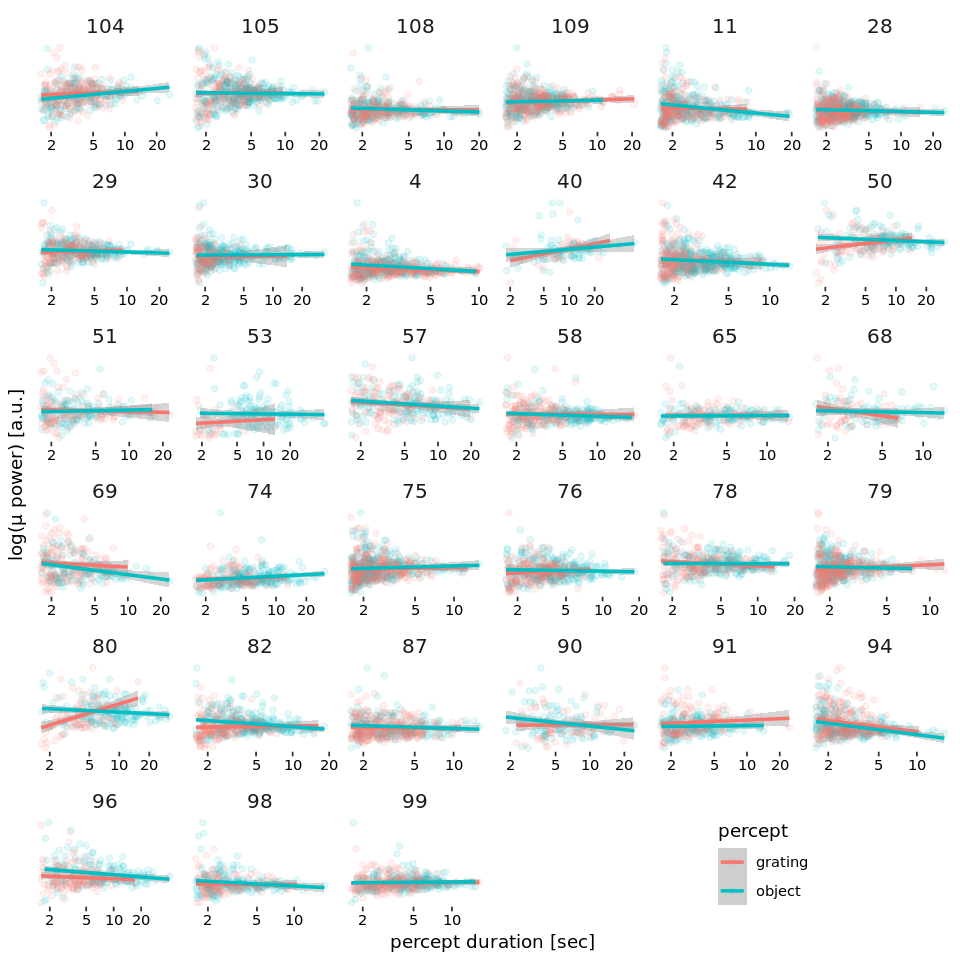

In [911]:
options(repr.plot.width=8, repr.plot.height=8)

df.id.data <- data.frame()
df.id.corr <- data.frame()
for (i in unique(df.corr$id)) {
    for (k in c("object","grating")) {
        
        # Partial out alpha
        tmp.log_dur <- resid(lm(data = filter(df.corr, id==i, percept==k),
                                    log_dur ~ log_alpha))
        tmp.log_mu <- resid(lm(data = filter(df.corr, id==i, percept==k),
                                    log_mu ~ log_alpha))
        df.id.data <- bind_rows(df.id.data,
                                data.frame(id = i, percept = k,
                                           log_dur = filter(df.corr, id==i, percept==k)$log_dur,
                                           log_mu = filter(df.corr, id==i, percept==k)$log_mu))
        
        # Spearman correlation
        tmp <- cor.test(tmp.log_dur, tmp.log_mu, method = "spearman")

        df.id.corr <- bind_rows(df.id.corr, data.frame(id = i, percept = k, cor = tmp$estimate))
    }
}

# Average individual-level correlation coefficient
df.id.corr %>% group_by(percept) %>% summarise_if(is.double, mean)

# Plot
ggplot(df.id.data, aes(x = exp(log_dur), y = exp(log_mu), color = percept)) +
facet_wrap(. ~ id, ncol = 6, scales = "free") +
geom_point(alpha=.1) +
geom_smooth(method = "lm") +
scale_x_continuous(breaks = c(2,5,10,20), trans="log") + 
scale_y_continuous(breaks = scales::pretty_breaks(3)) +
labs(x = "percept duration [sec]", y = "log(µ power) [a.u.]") +
theme(axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      legend.position = c(.8,.05))

# **FIGURES**

## **Table 1**: characteristics of participants

In [85]:
df.table <- df.demographics %>%
    mutate(group = recode(as.factor(group), "NVM" = "Novices", "LTM" = "LTMs")) %>%
    group_by(group) %>% 
    summarise(n = format.digits(n(),0),
              n_F = format.digits(sum(sex=="F"),0),
              n_M = format.digits(sum(sex=="M"),0),
              age_M = format.digits(mean(age, na.rm=T),1),
              age_SD = format.digits(sd(age, na.rm=T),1),
              educ_M = format.digits(mean(education, na.rm=T),1),
              educ_SD = format.digits(sd(education, na.rm=T),1)) %>%
    
    mutate(Sex = paste0(n_F,"F/",n_M,"M"), 
           Age = paste0(age_M," (",age_SD,")"),
           Education = paste0(educ_M," (",educ_SD,")")) %>%

    select(-contains("_"))


tbl = table(df.demographics$sex, df.demographics$group)
t.sex = chisq.test(tbl) 
t.age = t.test(filter(df.demographics,group=="NVM")$age,
               filter(df.demographics,group=="LTM")$age)
t.educ = t.test(filter(df.demographics,group=="NVM")$education,
                filter(df.demographics,group=="LTM")$education)

df.table <- bind_rows(df.table,
                      data.frame(group="$p$", n="", Sex=t.sex$p.value, Age=t.age$p.value, Education=t.educ$p.value) %>%
                         mutate_if(is.double,format.p))

rownames(df.table) = c()

df.table

group   n  Sex    Age        Education
1 Novices 19 8F/11M 54.0 (7.8) 4.3 (2.1)
2 LTMs    14 4F/10M 53.3 (7.1) 2.7 (2.5)
3 $p$        .67    .79        .069

## **Figure 2**: Effects of manipulations on behavior

### Percept duration (log-ratio)

`summarise()` has grouped output by 'id', 'group', 'state'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'state'. You can override using the `.groups` argument.
Joining, by = c("group", "state", "aff")


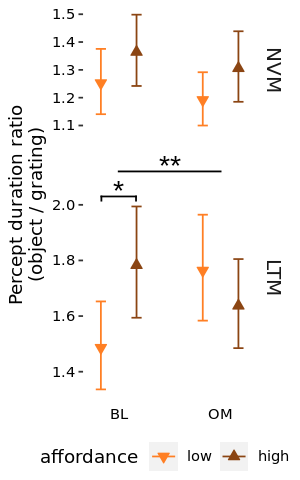

In [318]:
options(repr.plot.width=2.5, repr.plot.height=4)


df.plot.SE <- summarySEwithin(data = df.dur.ratio, measurevar = "log_ratio", idvar = "id", 
                              withinvars = c("state","aff"), betweenvars=c("group"), na.rm=T)

df.plot.means <- summarySE(data = df.dur.ratio, measurevar = "log_ratio",
                           groupvars = c("group","state","aff"), na.rm=T) %>% 
    select(group,state,aff,log_ratio)

df.plot.means <- df.dur.ratio %>%        
    group_by(id,group,state,aff) %>%
    summarise(log_ratio = mean(log_ratio, na.rm=T)) %>% 
    group_by(group,state,aff) %>% summarise(log_ratio = mean(log_ratio, na.rm=T))

df.plot <- left_join(df.plot.SE %>% select(-log_ratio), df.plot.means)

#f.plot.SE <- df.plot.SE %>% mutate(group = factor(group, levels = c("NVM","LTM")))
#summary(df.plot.SE)

g <- ggplot(df.plot, aes(x = state, y = exp(log_ratio), color = aff, fill = aff, shape = aff)) +

# --- data
facet_grid(as.factor(group) ~ ., space = "free", scale = "free_y") +

geom_errorbar(aes(ymin=exp(log_ratio-ci), ymax=exp(log_ratio+ci)), position=position_dodge(.7), width=.2) +
geom_point(size = 2, position=position_dodge(.7)) +


# --- significance for experts
# --- interaction
geom_segment(data = data.frame(x=1, xend=2, y=2.12, group="LTM", aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_text(data = data.frame(x=1.5, y=2.14, group="LTM", aff="low"),
          aes(x=x,y=y), label="**", size=6, color="black") +
# --- RS
geom_segment(data = data.frame(x=0.83, xend=1.17, y=2.03, group="LTM", aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_segment(data = data.frame(x=0.83, yend=2.03, group="LTM", aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_segment(data = data.frame(x=1.17, yend=2.03, group="LTM", aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_text(data = data.frame(x=1, y=2.05, group="LTM", aff="low"),
          aes(x=x,y=y), label="*", size=6, color="black") +

# --- cosmetics
scale_y_continuous(breaks = scales::pretty_breaks(5)) +
scale_x_discrete(expand = expansion(mult=c(0))) +
scale_colour_manual(values = aff.colors, aesthetics = c("color","fill")) +
scale_shape_manual(values = c(25,24)) +

labs(y = "Percept duration ratio\n(object / grating)",
     color = "affordance", fill = "affordance", shape="affordance") +
theme(axis.ticks.x = element_blank(),
      axis.title.x = element_blank(),
      legend.position = "bottom",
#       plot.title = element_text(hjust = .5),
      panel.spacing = unit(0.5,"cm"))

g.dur.ratio <- g
g

### Percept duration (raw)

Joining, by = c("group", "percept", "state", "aff")


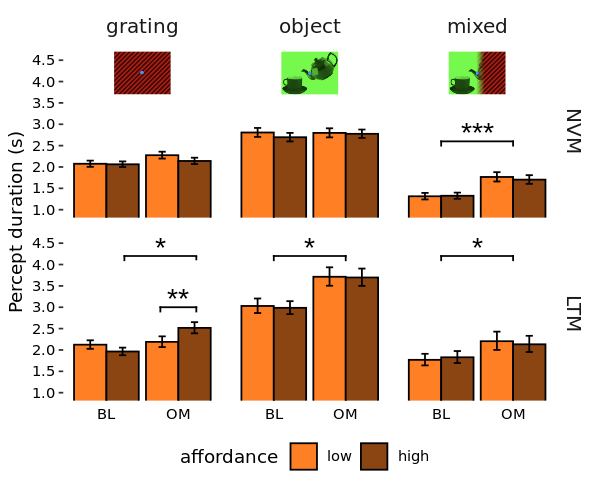

In [235]:
df.tmp <- df.measures %>% mutate(log_dur = log(dur), run==lead(run))

df.plot.SE <- summarySEwithin(data = df.tmp,
                              measurevar = "log_dur", idvar = "id", 
                              withinvars = c("percept","state",'aff'), betweenvars=c("group"))

df.plot.means <- summarySE(data = df.tmp, measurevar = "log_dur",
                           groupvars = c("group","percept","state","aff"), na.rm=T) %>% 
    select(group,percept,state,aff,log_dur)

df.plot <- left_join(df.plot.SE %>% select(-log_dur), df.plot.means)

options(repr.plot.width=5, repr.plot.height=4)

g <- ggplot(df.plot, aes(x = state, y = exp(log_dur), fill = aff)) +
facet_grid(as.factor(group) ~ as.factor(percept), scales = "free_y") +

# --- data
geom_bar(stat="identity", color="black", position=position_dodge(.9)) +
geom_errorbar(aes(ymin=exp(log_dur-ci), ymax=exp(log_dur+ci)), position=position_dodge(.9), width=.2) +


# --- significance for mixed in novices
geom_segment(data = data.frame(x=1, xend=2, y=2.6, group="NVM", percept="mixed",aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square") +
geom_segment(data = data.frame(x=1, yend=2.6, group="NVM", percept="mixed",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_segment(data = data.frame(x=2, yend=2.6, group="NVM", percept="mixed",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_text(data = data.frame(x=1.5, y=2.8, group="NVM", percept="mixed",aff="low"),
          aes(x=x,y=y), label="***", size=6) +

# --- significance for GRATING in experts
# --- OM: low vs. high aff
geom_segment(data = data.frame(x=1.75, xend=2.25, y=3.0, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square") +
geom_segment(data = data.frame(x=1.75, yend=3.0, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_segment(data = data.frame(x=2.25, yend=3.0, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_text(data = data.frame(x=2, y=3.2, group="LTM", percept="grating",aff="low"),
          aes(x=x,y=y), label="**", size=6) +
# --- high aff: BL vs. OM
geom_segment(data = data.frame(x=1.25, xend=2.25, y=4.2, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square") +
geom_segment(data = data.frame(x=1.25, yend=4.2, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_segment(data = data.frame(x=2.25, yend=4.2, group="LTM", percept="grating",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend)) +
geom_text(data = data.frame(x=1.75, y=4.4, group="LTM", percept="grating",aff="low"),
          aes(x=x,y=y), label="*", size=6) +

# # --- significance for OBJECT in experts
geom_segment(data = data.frame(x=1, xend=2, y=4.2, group="LTM", percept="object",aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square") +
geom_segment(data = data.frame(x=1, yend=4.2, group="LTM", percept="object",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_segment(data = data.frame(x=2, yend=4.2, group="LTM", percept="object",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_text(data = data.frame(x=1.5, y=4.4, group="LTM", percept="object",aff="low"),
          aes(x=x,y=y), label="*", size=6) +

# --- significance for MIXED in experts
geom_segment(data = data.frame(x=1, xend=2, y=4.2, group="LTM", percept="mixed",aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square") +
geom_segment(data = data.frame(x=1, yend=4.2, group="LTM", percept="mixed",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_segment(data = data.frame(x=2, yend=4.2, group="LTM", percept="mixed",aff="low"),
             aes(x=x, xend=x, y=yend-0.1, yend=yend), lineend="square") +
geom_text(data = data.frame(x=1.5, y=4.4, group="LTM", percept="mixed",aff="low"),
          aes(x=x,y=y), label="*", size=6)

# --- pictures
img1 = readPNG("./grating_color.png")
img2 = readPNG("./object_color.png")
img3 = readPNG("./mixed_color.png")
a1 = annotation_custom2(rasterGrob(img1, interpolate=TRUE), xmin=1, xmax=2, ymin=3.7, ymax=4.7,
                        data = (df.plot.SE %>% filter(group == "NVM", percept=="grating"))[1,])
a2 = annotation_custom2(rasterGrob(img2, interpolate=TRUE), xmin=1, xmax=2, ymin=3.7, ymax=4.7,
                        data = (df.plot.SE %>% filter(group == "NVM", percept=="object"))[1,])
a3 = annotation_custom2(rasterGrob(img3, interpolate=TRUE), xmin=1, xmax=2, ymin=3.7, ymax=4.7,
                        data = (df.plot.SE %>% filter(group == "NVM", percept=="mixed"))[1,])

# --- aesthetics
g <- g + coord_cartesian(ylim = c(1.0,4.7)) +
scale_x_discrete(labels=c("BL","OM")) +
scale_y_continuous(breaks = seq(1,4.5,0.5)) +
scale_colour_manual(values = aff.colors, aesthetics = c("color","fill")) +


labs(y = "Percept duration (s)", fill="affordance") +
# guides(fill = FALSE) +
theme(#axis.text.x = element_text(angle = 45, hjust = 1),
      axis.ticks.x = element_blank(),
      axis.title.x = element_blank(),
      legend.position = "bottom")

g.dur  <- g + a1 + a2 + a3
g.dur

### Compounded figure

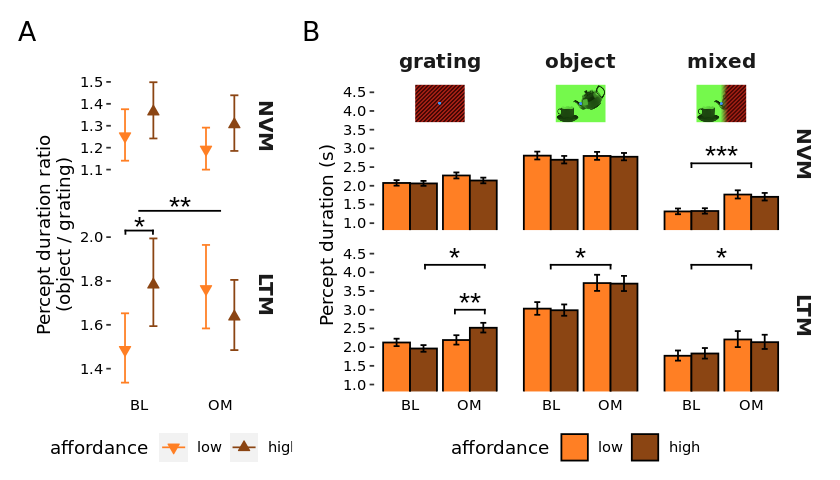

In [788]:
options(repr.plot.width=7, repr.plot.height=4)

(g.dur.ratio) +  g.dur + plot_layout(widths = c(.25,.75)) +
plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 16),
                                          strip.text = element_text(face = "bold")) -> g

g
ggsave(g, filename = "./fig_2.png",
       width = 7, height = 4, dpi=600)

## **Figure 3**: Effects of affordance on mu & subjective realism

### Mu

Joining, by = c("state", "aff")


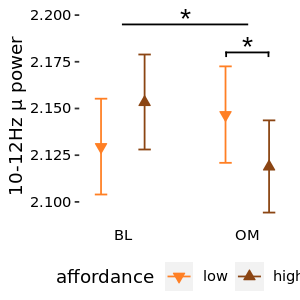

In [780]:
# Calculate within-subject SE
df.plot.SE <- summarySEwithin(data = df.mu, measurevar = "log_mu", idvar = "id", 
                              withinvars = c("state","aff"), na.rm=T)

df.plot.means <- df.mu %>%        
    group_by(id,state,aff) %>% summarise(log_mu = mean(log_mu, na.rm=T)) %>% 
    group_by(state,aff) %>% summarise(log_mu = mean(log_mu, na.rm=T))


df.plot <- left_join(df.plot.SE %>% select(-log_mu), df.plot.means)


options(repr.plot.width=2.5, repr.plot.height=2.5)

g <- ggplot(df.plot,
            aes(x = state, y = exp(log_mu), color = aff, fill = aff, shape = aff)) +

# --- data
geom_errorbar(aes(ymin=exp(log_mu-ci), ymax=exp(log_mu+ci)),
              position=position_dodge(.7), width=.2) +
geom_point(size=2, position=position_dodge(.7)) + 


# --- statistics: interaction
geom_segment(data = data.frame(x=1, xend=2, y=2.195, state="BL", aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_text(data = data.frame(x=1.5, y=2.198, state="BL", aff="low"),
          aes(x=x,y=y), label="*", size=6, color="black") +

# --- statistics: effect of affordance in OM
geom_segment(data = data.frame(x=1.83, xend=2.17, y=2.18, aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_segment(data = data.frame(x=1.83, yend=2.18, aff="low"),
             aes(x=x, xend=x, y=yend-0.002, yend=yend), lineend="square", color="black") +
geom_segment(data = data.frame(x=2.17, yend=2.18, aff="low"),
             aes(x=x, xend=x, y=yend-0.002, yend=yend), lineend="square", color="black") +
geom_text(data = data.frame(x=2, y=2.183, aff="low"),
          aes(x=x,y=y), label="*", size=6, color="black") +

# --- aesthetics
scale_x_discrete(expand = expansion(mult=c(0))) +
expand_limits(y = 2.195) +
scale_color_manual(values = aff.colors) +
scale_fill_manual(values = aff.colors) +


scale_shape_manual(values = c(25,24))+

labs(y = "10-12Hz µ power",
     color = "affordance", fill = "affordance", shape = "affordance") +

theme(axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

g.mu <- g
g

### Subjective realism

`summarise()` has grouped output by 'id', 'state'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the `.groups` argument.
Joining, by = c("state", "aff")


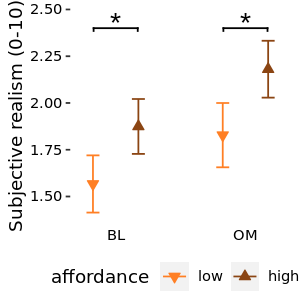

In [317]:
# Calculate within-subject SE
df.plot.SE <- summarySEwithin(data = df.scales, measurevar = "subjreal", idvar = "id", 
                              withinvars = c("state","aff"), na.rm=T) #betweenvars="group", 

df.plot.means <- df.scales %>%        
    group_by(id,state,aff) %>%
    summarise(subjreal = mean(subjreal, na.rm=T)) %>% 
    group_by(state,aff) %>% summarise(subjreal = mean(subjreal, na.rm=T))

df.plot <- left_join(df.plot.SE %>% select(-subjreal), df.plot.means)


options(repr.plot.width=2.5, repr.plot.height=2.5)

g <- ggplot(df.plot,
            aes(x = state, y = subjreal, color = aff, fill = aff, shape = aff)) +

# --- data
geom_errorbar(aes(ymin=subjreal-ci, ymax=subjreal+ci),
              position=position_dodge(.7), width=.2) +
geom_point(size=2, position=position_dodge(.7)) + 

# --- statistics: effet of affordance
# --- RS
geom_segment(data = data.frame(x=0.83, xend=1.17, y=2.4, aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_segment(data = data.frame(x=0.83, yend=2.4, aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_segment(data = data.frame(x=1.17, yend=2.4, aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_text(data = data.frame(x=1, y=2.43, aff="low"),
          aes(x=x,y=y), label="*", size=6, color="black") +
# --- OM
geom_segment(data = data.frame(x=1.83, xend=2.17, y=2.4, aff="low"),
             aes(x=x, xend=xend, y=y, yend=y), lineend="square", color="black") +
geom_segment(data = data.frame(x=1.83, yend=2.4, aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_segment(data = data.frame(x=2.17, yend=2.4, aff="low"),
             aes(x=x, xend=x, y=yend-0.015, yend=yend), lineend="square", color="black") +
geom_text(data = data.frame(x=2, y=2.43, aff="low"),
          aes(x=x,y=y), label="*", size=6, color="black") +

# --- aesthetics
scale_x_discrete(expand = expansion(mult=c(0))) +
expand_limits(y = 2.45) +

scale_color_manual(values = aff.colors, aesthetics = c("color","fill")) +
scale_shape_manual(values = c(25,24))+

labs(y = "Subjective realism (0-10)",
     color = "affordance", fill = "affordance", shape = "affordance") +

theme(axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

g.subjreal <- g
g

Warning message:
“Removed 263 rows containing non-finite values (stat_binline).”


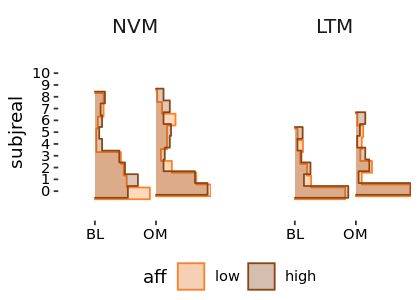

In [115]:
# An alternative way of representing the ordinal distributions

library(ggridges)

ggplot(df.scales, aes(x = subjreal, y = state, color = aff, fill = aff)) +
facet_grid(. ~ group) +
geom_density_ridges(stat = "binline", breaks = seq(-0.5,10.5),
                    position = position_dodge(.5),
                    scale = .9, alpha = .3, draw_baseline = F) +

scale_x_continuous(breaks = seq(0,10)) +
scale_color_manual(values = aff.colors, aesthetics = c("color","fill")) +
coord_flip() +

theme(axis.title.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

### Compounded figure

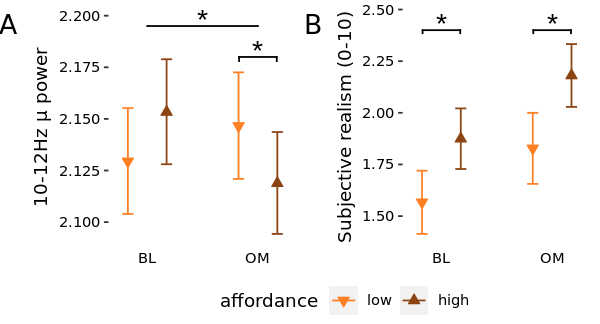

In [781]:
options(repr.plot.width = 5, repr.plot.height = 2.7)
# (ggplot() + theme_void()) +
(g.mu + theme(plot.margin = margin(l = 15))) +
(g.subjreal + theme(plot.margin = margin(l = 25))) +
plot_layout(guides = 'collect') + plot_annotation(tag_levels = 'A') &
theme(legend.position = "bottom",
      axis.ticks.x = element_blank(),
      plot.tag = element_text(size = 16),
      plot.tag.position = c(-0.1, 0.95)) -> g

g

ggsave(g, filename = "./fig_3.png",
       width = 5, height = 2.7, dpi=600)

# **SUPPLEMENTARY FIGURES**

## **Supp figure 1**: effects of manipulations on mu & subjective realism

### Mu

Joining, by = c("group", "state", "aff")


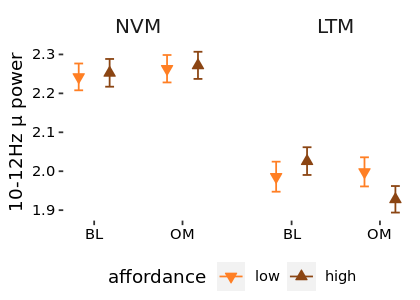

In [782]:
# Calculate within-subject SE
df.plot.SE <- summarySEwithin(data = df.mu, measurevar = "log_mu", idvar = "id", 
                              withinvars = c("state","aff"), betweenvars="group", na.rm=T)

df.plot.means <- df.mu %>%        
    group_by(group,id,state,aff) %>% summarise(log_mu = mean(log_mu, na.rm=T)) %>% 
    group_by(group, state,aff) %>% summarise(log_mu = mean(log_mu, na.rm=T))

df.plot <- left_join(df.plot.SE %>% select(-log_mu), df.plot.means)



options(repr.plot.width=3.5, repr.plot.height=2.5)

g <- ggplot(df.plot,
            aes(x = state, y = exp(log_mu), color = aff, fill = aff, shape = aff)) +
facet_grid(. ~ group) +

# --- data
geom_errorbar(aes(ymin=exp(log_mu-ci), ymax=exp(log_mu+ci)),
              position=position_dodge(.7), width=.2) +
geom_point(size=2, position=position_dodge(.7)) + 

# --- aesthetics
scale_x_discrete(expand = expansion(mult=c(0))) +
expand_limits(y = 2.195) +
scale_color_manual(values = aff.colors, aesthetics = c("color","fill")) +
scale_shape_manual(values = c(25,24))+

labs(y = "10-12Hz µ power",
     color = "affordance", fill = "affordance", shape = "affordance") +

theme(axis.title.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

g.mu <- g
g

### Subjective realism

Joining, by = c("group", "state", "aff")


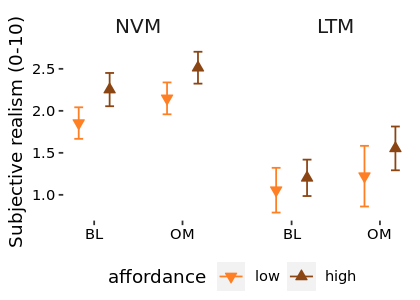

In [784]:
# Calculate within-subject SE
df.plot.SE <- summarySEwithin(data = df.scales, measurevar = "subjreal", idvar = "id", 
                              withinvars = c("state","aff"), betweenvars="group", na.rm=T) 

df.plot.means <- df.scales %>%
    group_by(group,id,state,aff) %>% summarise_if(is.double, mean, na.rm=T) %>% 
    group_by(group,state,aff) %>% summarise_if(is.double, mean, na.rm=T) %>% 
    select(group,state,aff,subjreal)

df.plot <- left_join(df.plot.SE %>% select(-subjreal), df.plot.means)


options(repr.plot.width=3.5, repr.plot.height=2.5)

g <- ggplot(df.plot,
            aes(x = state, y = subjreal, color = aff, fill = aff, shape = aff)) +
facet_grid(. ~ group) +

# --- data
geom_errorbar(aes(ymin=subjreal-ci, ymax=subjreal+ci),
              position=position_dodge(.7), width=.2) +
geom_point(size=2, position=position_dodge(.7)) + 

# --- aesthetics
scale_x_discrete(expand = expansion(mult=c(0))) +
scale_color_manual(values = aff.colors, aesthetics = c("color","fill")) +
scale_shape_manual(values = c(25,24))+

labs(y = "Subjective realism (0-10)",
     color = "affordance", fill = "affordance", shape = "affordance") +

theme(axis.title.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

g.subjreal <- g
g

### Compounded figure

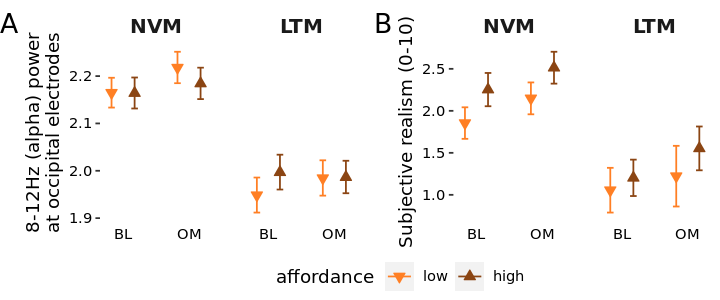

In [914]:
options(repr.plot.width=6, repr.plot.height=2.5)
(g.mu + theme(plot.margin = margin(l = 10))) +
(g.subjreal + theme(plot.margin = margin(l = 25))) +
plot_layout(guides = 'collect') + plot_annotation(tag_levels = 'A') &
theme(legend.position = "bottom",
      axis.ticks.x = element_blank(),
      plot.tag = element_text(size = 16),
      plot.tag.position = c(-0.05, .95),
      strip.text = element_text(face = "bold"),
      panel.spacing.x = unit(20,"pt")) -> g

g

ggsave(g, filename = "./fig_supp_1.png",
       width = 6, height = 2.5, dpi=600)

## **Supp figure 2**: occipital alpha

Joining, by = c("group", "state", "aff")


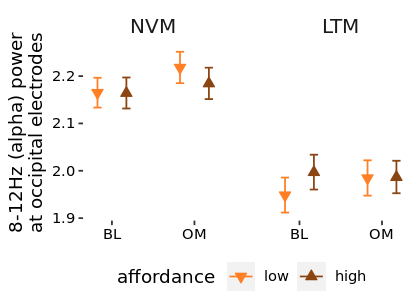

In [786]:
# Calculate within-subject SE
df.plot.SE <- summarySEwithin(data = df.mu, measurevar = "log_alpha", idvar = "id", 
                              withinvars = c("state","aff"), betweenvars="group", na.rm=T)

df.plot.means <- df.mu %>%        
    group_by(group,id,state,aff) %>% summarise(log_alpha = mean(log_alpha, na.rm=T)) %>% 
    group_by(group, state,aff) %>% summarise(log_alpha = mean(log_alpha, na.rm=T))

df.plot <- left_join(df.plot.SE %>% select(-log_alpha), df.plot.means)



options(repr.plot.width=3.5, repr.plot.height=2.5)

g <- ggplot(df.plot,
            aes(x = state, y = exp(log_alpha), color = aff, fill = aff, shape = aff)) +
facet_grid(. ~ group) +

# --- data
geom_errorbar(aes(ymin=exp(log_alpha-ci), ymax=exp(log_alpha+ci)),
              position=position_dodge(.7), width=.2) +
geom_point(size=2, position=position_dodge(.7)) + 

# --- aesthetics
scale_x_discrete(expand = expansion(mult=c(0))) +
expand_limits(y = 2.195) +
scale_color_manual(values = aff.colors, aesthetics = c("color","fill")) +
scale_shape_manual(values = c(25,24))+

labs(y = "8-12Hz (alpha) power\nat occipital electrodes",
     color = "affordance", fill = "affordance", shape = "affordance") +

theme(axis.title.x = element_blank(),
      legend.position = "bottom",
      plot.title = element_text(hjust = .5),
      panel.spacing = unit(1,"cm"))

g.mu <- g
g

## **Supp figure 3**: temporal trends

In [ ]:
# Function to generate summary statics: within-subject SE and global means

create_run_data <- function(df,measure) {
    
    df.tmp.SE <- summarySEwithin(data = df, measurevar = measure, idvar = "id", withinvars = c("run"), na.rm=T) %>% 
        mutate(run = as.numeric(run))
    df.tmp.M <- summarySE(data = df, measurevar = measure, groupvars = c("run"), na.rm=T) %>% select(any_of(measure), run)

    return(left_join(df.tmp.SE %>% select(-any_of(measure)), df.tmp.M))
}

### Percept duration (log-ratio)

Automatically converting the following non-factors to factors: run

Joining, by = "run"


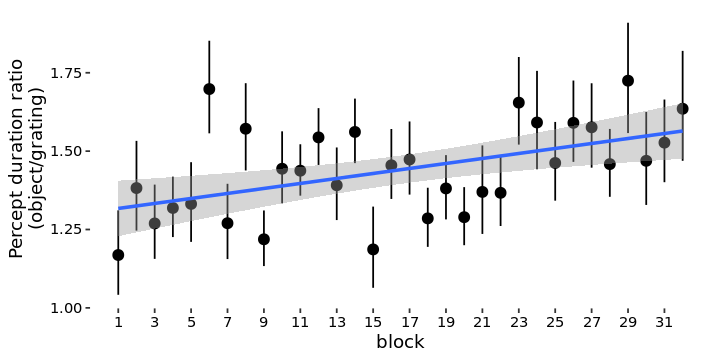

In [478]:
ggplot(df.dur.ratio %>% create_run_data("log_ratio"),
       aes(x = run, y = exp(log_ratio), ymin = exp(log_ratio-se), ymax = exp(log_ratio+se))) +
geom_pointrange() +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Percept duration ratio\n(object/grating)") -> g1

options(repr.plot.width=6, repr.plot.height=3)
g1

### Percept duration (raw)

Automatically converting the following non-factors to factors: run

Joining, by = "run"


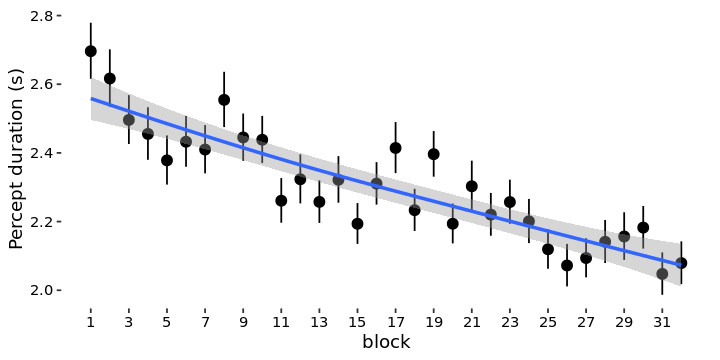

In [479]:
ggplot(df.measures %>% mutate(log_dur = log(dur), run==lead(run)) %>% create_run_data("log_dur"),
       aes(x = run, y = exp(log_dur), ymin = exp(log_dur-se), ymax = exp(log_dur+se))) +
geom_pointrange() +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Percept duration (s)") -> g2

options(repr.plot.width=6, repr.plot.height=3)
g2

### Mu

Automatically converting the following non-factors to factors: run

Joining, by = "run"


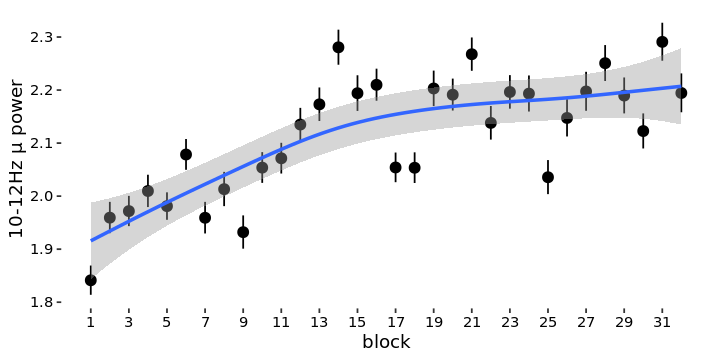

In [481]:
ggplot(df.mu %>% mutate(run==lead(run)) %>% create_run_data("log_mu"),
       aes(x = run, y = exp(log_mu), ymin = exp(log_mu-se), ymax = exp(log_mu+se))) +
geom_pointrange() +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "10-12Hz µ power") -> g3

options(repr.plot.width=6, repr.plot.height=3)
g3

### Subjective realism

Automatically converting the following non-factors to factors: run

Joining, by = "run"


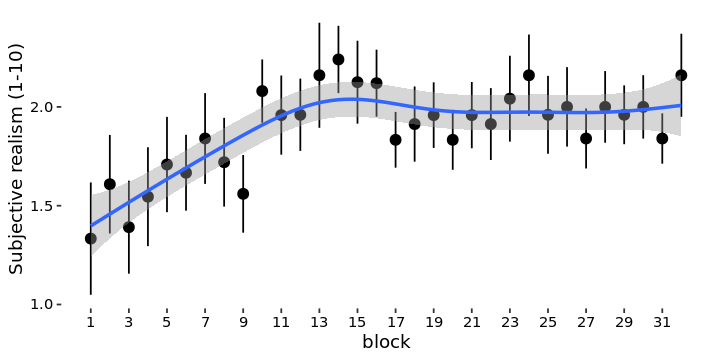

In [482]:
ggplot(df.scales %>% create_run_data("subjreal"),
       aes(x = run, y = subjreal, ymin = (subjreal-se), ymax = (subjreal+se))) +
geom_pointrange() +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Subjective realism (1-10)") -> g4

options(repr.plot.width=6, repr.plot.height=3)
g4

### Compounded figure

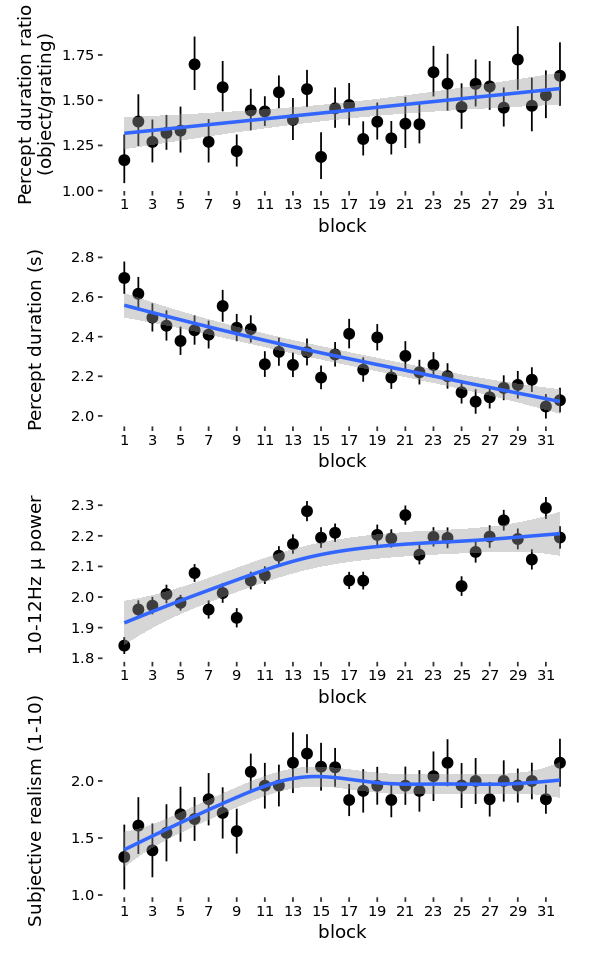

In [491]:
options(repr.plot.width=5, repr.plot.height=8)
g1 / g2 / g3 / g4 -> g

g
ggsave(g, filename = "./fig_supp_3.png",
       width = 5, height = 8, dpi=600)

# **Conversion to Rmd**

In [916]:
library(rmarkdown)
input = "RIV_analysis_final.ipynb"
rmarkdown:::convert_ipynb(input, output = "RIV_analysis_final.Rmd")

Warning message:
“package ‘rmarkdown’ was built under R version 4.1.1”


In [ ]:
# Shell code for html with ToC:
# jupyter nbconvert <file> --to html_toc --ExtractOutputPreprocessor.enabled=False

# **SANDBOX**

## Mu power: regressing out occipital alpha

Conclusion: does not change the pattern of results

In [752]:
m.mu.alpha <- lmer(data = df.mu,
             log_mu ~ (group+state+aff)^3 + percept + log_alpha + run +
                      (1+state+aff+percept|id) + (0+log_alpha|id) + (0+run|id),
             #control = lmerControl(optimizer="bobyqa"),
             contrasts=list(group=c(-0.5,0.5),state=c(-0.5,0.5),aff=c(-0.5,0.5)))

AIC(m.mu.alpha)
anova(m.mu.alpha)
summary(m.mu.alpha)

# AIC
# without percept : 11755
# + percept : 11546
# + percept + log_alpha : 8581

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.116185 (tol = 0.002, component 1)”


[1] 8581.19

Sum Sq      Mean Sq     NumDF DenDF       F value    
group            0.07514910  0.07514910 1        29.43738   0.8030890
state            0.03584288  0.03584288 1        45.96670   0.3830388
aff              0.07015442  0.07015442 1        35.08471   0.7497128
percept          1.04893270  0.52446635 2        31.28243   5.6047663
log_alpha       14.92498862 14.92498862 1        30.26549 159.4975032
run              2.04995376  2.04995376 1        29.71791  21.9070523
group:state      0.05366720  0.05366720 1        96.01564   0.5735203
group:aff        0.24883306  0.24883306 1        34.17130   2.6591814
state:aff        0.53138748  0.53138748 1     16440.24179   5.6787297
group:state:aff  0.27939706  0.27939706 1     16421.17422   2.9858069
                Pr(>F)      
group           3.774416e-01
state           5.390366e-01
aff             3.924498e-01
percept         8.310357e-03
log_alpha       1.343685e-13
run             5.849493e-05
group:state     4.507179e-01
group:aff       1.121380e-01
state:aff       1.718309e-02
group:state:aff 8.401621e-02

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_mu ~ (group + state + aff)^3 + percept + log_alpha + run +  
    (1 + state + aff + percept | id) + (0 + log_alpha | id) +  
    (0 + run | id)
   Data: df.mu

REML criterion at convergence: 8521.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.4124 -0.4919  0.0355  0.5588  4.8283 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr                   
 id       (Intercept) 1.771e-01 0.420815                        
          state1      1.013e-04 0.010064 -0.15                  
          aff1        1.830e-04 0.013528  0.15  0.31            
          percept1    5.590e-04 0.023644  0.02 -0.96 -0.50      
          percept2    9.660e-04 0.031081 -0.23 -0.10  0.22 -0.07
 id.1     log_alpha   2.822e-02 0.167978                        
 id.2     run         9.617e-06 0.003101                        
 Residual             9.358e-02 0.305900                        

Could not compute standard errors from random effects for diagnostic plot.


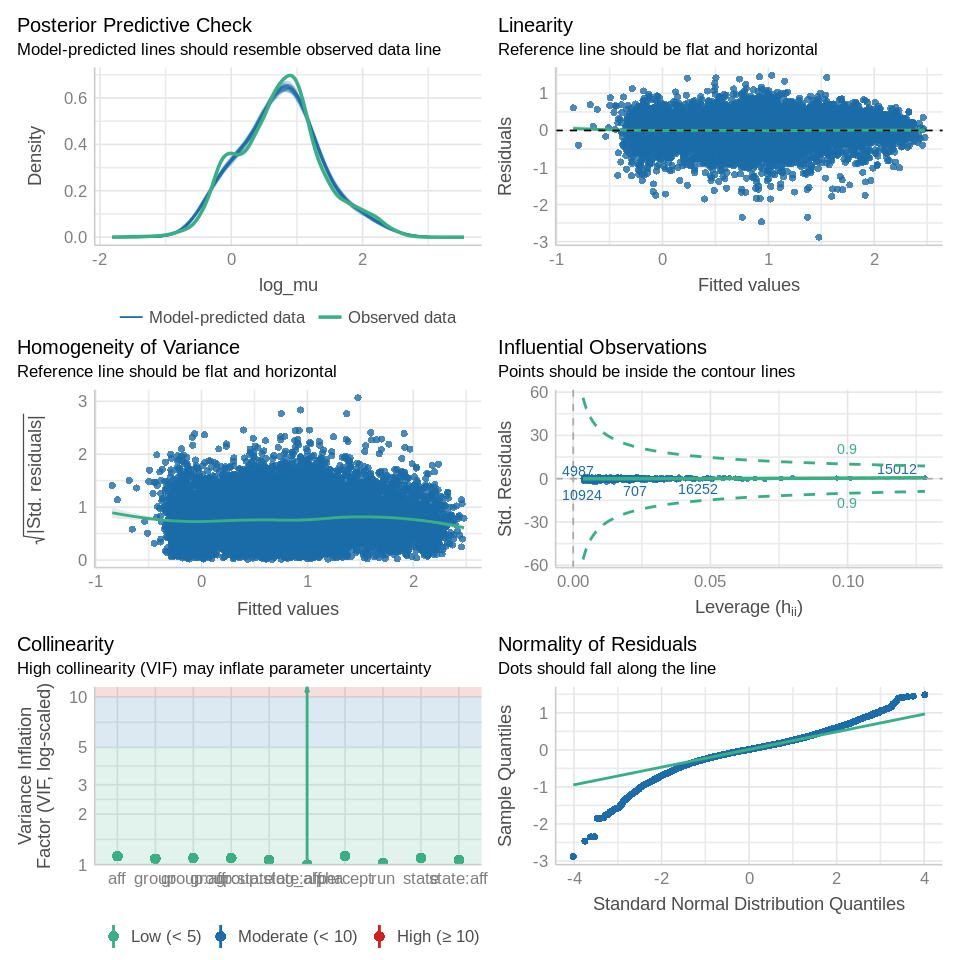

In [747]:
options(repr.plot.width=8, repr.plot.height=8)

check_model(m.mu.alpha) # may take a minute

## Mu power: find optimal duration threshold

Because of the [-1,0.6] exclusion window, µ power can not be calculated for percepts lasting less than 1.6s, and percepts lasting oly a little longer do not provide much signal for the power calculation, rendering the estimate possibly noisy. Therefore one could imagine that dropping short trials (i.e. below a certain duration threshold) could improve the SNR even though the sample size decreases. On the other hand, above a certain **optimal** duration threshold one starts discarding data with good signal and, therefore, loses statistical power.

Below we identify the optimal duration threshold by calculating the SEM of spectral power for each component (µ and alpha) and for a whole range of threshold values.

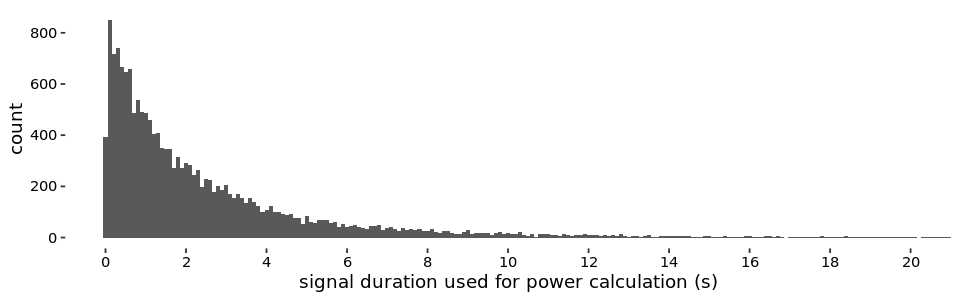

In [653]:
# Distribution of durations of useful signal (i.e. out of [-1, 0.6]) to calculate µ power
options(repr.plot.width=8, repr.plot.height=2.5)

ggplot(df.mu %>% filter(!is.na(log_mu)),
       aes(x = exp(log_dur)-1.6)) +
geom_histogram(binwidth = 0.1) +
scale_x_continuous(breaks = seq(0,20,2)) +
coord_cartesian(xlim = c(0,20)) +
labs(x = "signal duration used for power calculation (s)", y = "count")

In [643]:
MinDur <- seq(1.6,4.6,0.010)
MinDur <- (2)
SEM.mu <- vector("numeric", length(MinDur))
SEM.alpha <- vector("numeric", length(MinDur))
N <- vector("numeric", length(MinDur))
k <- 1

for (m in MinDur) {
    
    df.tmp <- df.measures %>%
        filter(dur > m)
    N[k] <- nrow(df.tmp)
    
    df.tmp <- df.tmp %>% 
        group_by(id) %>%
        summarise(SD.mu = sd(log(mu), na.rm=T),
                  SD.alpha = sd(log(alpha), na.rm=T)) %>% 
        ungroup() %>% summarise(SD.mu = mean(SD.mu, na.rm=T),
                                SD.alpha = mean(SD.alpha, na.rm=T))
    
    SEM.mu[k] <- df.tmp[[1,"SD.mu"]]/sqrt(N[k])
    SEM.alpha[k] <- df.tmp[[1,"SD.alpha"]]/sqrt(N[k])
    k <- k+1
}

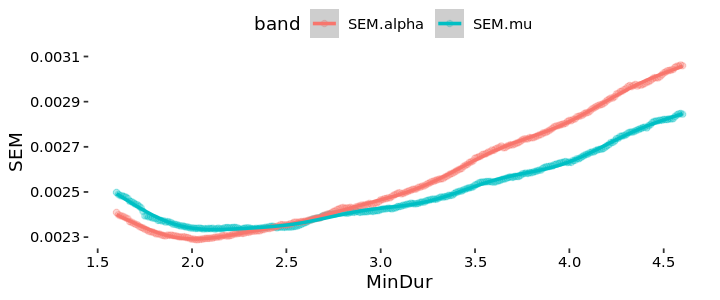

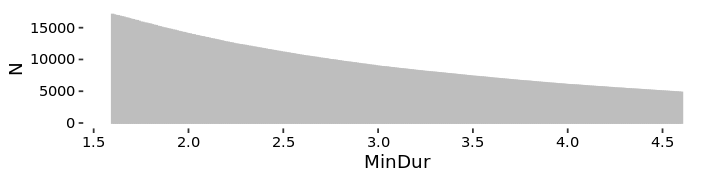

In [632]:
options(repr.plot.width=6, repr.plot.height=2.5)

ggplot(data.frame(MinDur, N, SEM.mu, SEM.alpha) %>% gather(band, SEM, starts_with("SEM.")),
       aes(x = MinDur, y = SEM, color = band)) +
geom_point(alpha = 0.3) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
scale_x_continuous(breaks = scales::pretty_breaks(8)) +
theme(legend.position = 'top') -> g
g

options(repr.plot.width=6, repr.plot.height=1.5)

ggplot(data.frame(MinDur, N),
       aes(x = MinDur, y = N)) +
geom_col(color = "grey", fill = "grey") +
scale_x_continuous(breaks = scales::pretty_breaks(8))

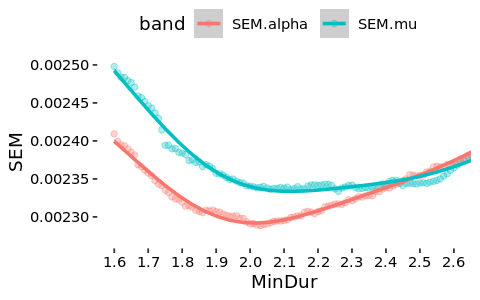

In [631]:
# Zoom in to identify optimal threshold (~ 2.05s)

options(repr.plot.width=4, repr.plot.height=2.5)
g + coord_cartesian(xlim = c(1.6, 2.6), ylim = c(0.00227, 0.0025))

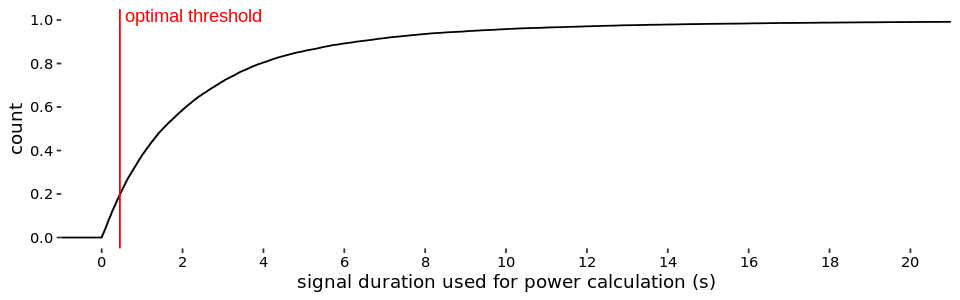

In [654]:
# Loss of data if the optimal threhsold was applied (~ 20%)
options(repr.plot.width=8, repr.plot.height=2.5)

ggplot(df.mu %>% filter(!is.na(log_mu)),
       aes(x = exp(log_dur)-1.6)) +
stat_ecdf() +
geom_vline(xintercept = 2.05-1.6, color = "red") +
annotate(geom="text", label = " optimal threshold", color="red", x=2.05-1.6, y=Inf, hjust=0, vjust=1) +
scale_x_continuous(breaks = seq(0,20,2)) +
scale_y_continuous(breaks = seq(0,1,.2)) +
coord_cartesian(xlim = c(0,20)) +
labs(x = "signal duration used for power calculation (s)", y = "count")

## Mu power: split-half model

In [677]:
df.mu %>% glimpse()

Rows: 13,677
Columns: 11
Groups: id, state [66]
$ group     <fct> LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, LTM, …
$ id        <fct> 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, …
$ state     <fct> BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, BL, …
$ run       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, …
$ img       <chr> "hammer", "hammer", "hammer", "hammer", "hammer", "hammer", …
$ aff       <fct> low, low, low, low, low, low, low, low, low, low, low, low, …
$ percept   <fct> object, grating, object, grating, object, grating, object, g…
$ log_dur   <dbl> 1.7250853, 1.2780686, 1.0270447, 1.3070076, 1.0867758, 1.340…
$ log_alpha <dbl> 0.9367206, 0.5482370, 0.1721029, 0.7520291, 0.2710953, 0.432…
$ log_mu    <dbl> 0.5243142, 0.6879839, 0.4795207, 0.9903216, 0.8791287, 0.854…
$ run.state <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, …


In [744]:
m.mu.1sthalf <- lmer(data = df.mu %>% filter(run <= 16),
                     log_mu ~ (group+state+aff)^3 + run + (1+state+aff|id) + (0+run|id),
                     control = lmerControl(optimizer="bobyqa"),
                     contrasts=list(group=c(-0.5,0.5),state=c(-0.5,0.5),aff=c(-0.5,0.5)))

anova(m.mu.1sthalf)
summary(m.mu.1sthalf)

boundary (singular) fit: see ?isSingular



Sum Sq       Mean Sq      NumDF DenDF    F value     
group           0.0317839859 0.0317839859 1     15.36769  0.290668096
state           0.0532411966 0.0532411966 1     28.16866  0.486896681
aff             0.0315438960 0.0315438960 1     41.46433  0.288472448
run             2.2328615506 2.2328615506 1     33.01834 20.419767921
group:state     0.0002263523 0.0002263523 1     28.16891  0.002070017
group:aff       0.0748787661 0.0748787661 1     41.46541  0.684774668
state:aff       0.0708894895 0.0708894895 1     41.41249  0.648292288
group:state:aff 0.4660523311 0.4660523311 1     41.40638  4.262100548
                Pr(>F)      
group           0.5975175184
state           0.4910350348
aff             0.5940717387
run             0.0000754991
group:state     0.9640318310
group:aff       0.4126846374
state:aff       0.4253227534
group:state:aff 0.0452731452

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_mu ~ (group + state + aff)^3 + run + (1 + state + aff | id) +  
    (0 + run | id)
   Data: df.mu %>% filter(run <= 16)
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 5671.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2528 -0.4914  0.0325  0.5471  4.1807 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr       
 id       (Intercept) 0.1178110 0.343236            
          state1      0.1638288 0.404758 -0.32      
          aff1        0.0001662 0.012893 -0.61 -0.56
 id.1     run         0.0000952 0.009757            
 Residual             0.1093480 0.330678            
Number of obs: 8580, groups:  id, 33

Fixed effects:
                    Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)         0.655526   0.091988 15.525046   7.126 2.85e-06 ***
group1             -0.099112   0.183834 15.367690  -0.539   0.5975 

In [762]:
emm <- emmeans(m.mu.1sthalf, ~ aff*group|state) 
contrast(emm, interaction = "revpairwise")

emmeans(m.mu.1sthalf, revpairwise ~ aff|group, at = list(state="BL"))$contrasts %>% emm_backtrans(exp)

emmeans(m.mu.1sthalf, revpairwise ~ aff|group, at = list(state="OM"))$contrasts %>% emm_backtrans(exp)

state = BL:
 aff_revpairwise group_revpairwise estimate     SE   df lower.CL upper.CL
 high - low      LTM - NVM           0.0227 0.0284 43.0  -0.0346   0.0799
 t.ratio p.value
   0.799  0.4289

state = OM:
 aff_revpairwise group_revpairwise estimate     SE   df lower.CL upper.CL
 high - low      LTM - NVM          -0.0530 0.0232 39.1  -0.0999  -0.0061
 t.ratio p.value
  -2.286  0.0278

Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

NOTE: Results may be misleading due to involvement in interactions



contrast   group estimate  SE         df       lower.CL  upper.CL t.ratio   
1 high / low NVM   0.9911663 0.01628202 37.12675 0.9590044 1.024407 -0.5449522
2 high / low LTM   1.0138833 0.02323975 46.33816 0.9675558 1.062429  0.5932869
  p.value  
1 0.5890453
2 0.5558741

NOTE: Results may be misleading due to involvement in interactions



contrast   group estimate  SE         df       lower.CL  upper.CL  t.ratio   
1 high / low NVM   1.0142943 0.01543785 33.70512 0.9829564 1.0466313  0.9193708
2 high / low LTM   0.9619576 0.01728935 44.47356 0.9290257 0.9960568 -2.2432834
  p.value   
1 0.36443484
2 0.02990753

## Subjective realism

### Zero-inflated Poisson models

In [ ]:
library(GLMMadaptive)

In [ ]:
m.subjreal.zip <- GLMMadaptive::mixed_model(data = df.scales,
                                            subjreal ~ group*state*aff + run, random = ~ 1+state+aff+run|id, 
                                            family = zi.poisson(), zi_fixed = ~ 1,
                                            control = list(iter_EM=0))

In [ ]:
m.subjreal.zip <- GLMMadaptive::mixed_model(data = df.scales,
                                            subjreal ~ group*state*aff + run, random = ~ 1+state+aff+run|id, 
                                            family = zi.poisson(), zi_fixed = ~ 1,
                                            control = list(iter_EM=0))

In [ ]:
summary(m.subjreal.zip)

In [ ]:
# no convergence (hessian matrix not positive definite) with random intercept for zi component

m.zip <- GLMMadaptive::mixed_model(data = df.scales %>% filter(state=="BL"),
                                   subjreal ~ aff + run, random = ~ 1+aff+run|id, 
                                   family = zi.poisson(), zi_fixed = ~ 1,
                                   control = list(iter_EM=0))

In [ ]:
marginal_coefs(m.zip)

In [ ]:
emmeans(m.zip, ~ aff) %>% pairs()

In [ ]:
anova(m.zip)
summary(m.zip)

### Ordinal models

In [ ]:
library(ordinal)

In [ ]:
df.model <- df.scales %>% mutate(subjreal = as.ordered(subjreal))

m.subjreal <- clmm(data = df.model,
                   subjreal ~ group*state*aff + run + (1+aff|id))

## Temporal trends

### Within a state session

In [493]:
create_run.state <- function(df) {
    df %>% 
        group_by(id,state) %>% mutate(run.state = run-min(run)+1) %>%
        # Note: subject #090 started with BL but switched to OM blocks too early (run #15 instead of #17)
        # and therefore finished with 2 blocks of BL (#31 & #32)
        filter(run.state <= 16) %>% 
        return()
}

In [337]:
df.measures$id %>% unique() %>% length()

df.measures %>% select(id,group,state,run) %>% distinct() %>% filter(run==1) %>% group_by(group,state) %>% count()

[1] 33

group state n
1 NVM   BL    8
2 NVM   OM    8
3 LTM   BL    5
4 LTM   OM    9

Warning message:
“Removed 35 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 35 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 35 rows containing non-finite values (stat_smooth).”


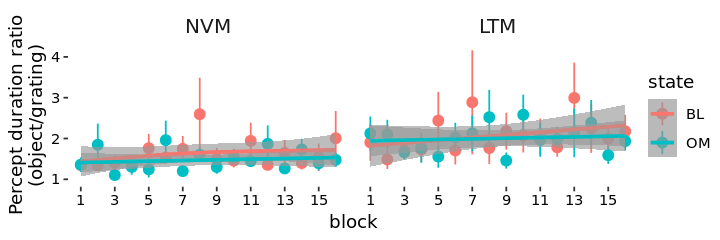

In [364]:
ggplot(create_run.state(df.dur.ratio),
       aes(x = (run.state), y = exp(log_ratio), color = state)) +
facet_grid(. ~ group) +
stat_summary(fun.data = mean_se) +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Percept duration ratio\n(object/grating)") -> g

options(repr.plot.width=6, repr.plot.height=2)
g

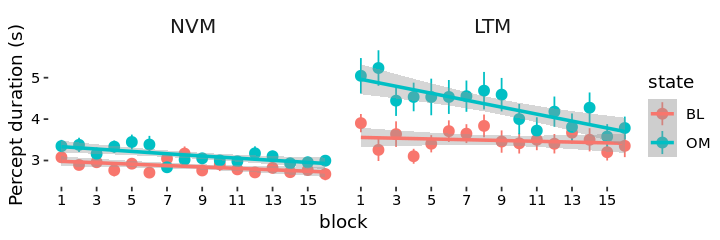

In [365]:
# Note: subject #090 started with BL but switched to OM blocks too early (run #15 instead of #17)
# and therefore finished with 2 blocks of BL (#31 & #32)
ggplot(create_run.state(df.measures),
       aes(x = (run.state), y = dur, color = state)) +
facet_grid(. ~ group) +
stat_summary(fun.data = mean_se) +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Percept duration (s)") -> g

options(repr.plot.width=6, repr.plot.height=2)
g

Warning message:
“Removed 3 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”


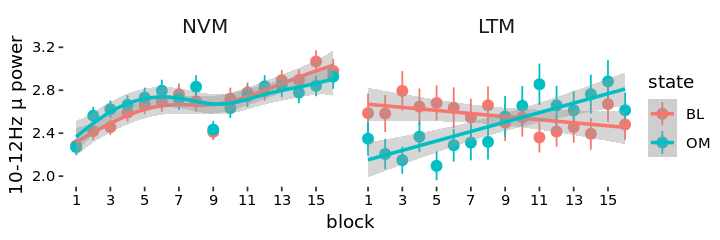

In [366]:
ggplot(create_run.state(df.mu),
       aes(x = (run.state), y = exp(log_mu), color = state)) +
facet_grid(. ~ group) +

stat_summary(fun.data = mean_se) +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "10-12Hz µ power") -> g

options(repr.plot.width=6, repr.plot.height=2)
g

In [419]:
# The group x state dissociation in temporal trends plotted above is statistically significant:

m <- lmer(data = df.mu,
          log_mu ~ run*(group+state+aff)^3 + (1+state+aff+run|id),
          control = lmerControl(optimizer="bobyqa"),
          contrasts=list(group=c(-0.5,0.5),state=c(-0.5,0.5),aff=c(-0.5,0.5)))

anova(m)
summary(m)

[1] 11829.32

Sum Sq     Mean Sq    NumDF DenDF       F value   
run                 2.97661466 2.97661466 1        28.59908 26.2010595
group               0.01412420 0.01412420 1        30.93114  0.1243255
state               0.08292951 0.08292951 1       184.19317  0.7299706
aff                 0.14771698 0.14771698 1       212.80550  1.3002494
group:state         1.39546515 1.39546515 1       184.19317 12.2833049
group:aff           0.20040955 0.20040955 1       212.80550  1.7640653
state:aff           0.36123701 0.36123701 1       126.79785  3.1797171
run:group           0.31123999 0.31123999 1        28.59908  2.7396282
run:state           0.17875622 0.17875622 1     15765.69379  1.5734662
run:aff             0.17961273 0.17961273 1     15919.18637  1.5810054
group:state:aff     0.23826379 0.23826379 1       126.79785  2.0972697
run:group:state     1.26698117 1.26698117 1     15765.69382 11.1523502
run:group:aff       0.15729722 0.15729722 1     15919.18640  1.3845776
run:state:aff       0.06672397 0.06672397 1        95.54020  0.5873245
run:group:state:aff 0.11348285 0.11348285 1        95.54020  0.9989102
                    Pr(>F)      
run                 1.893262e-05
group               7.267811e-01
state               3.940026e-01
aff                 2.554494e-01
group:state         5.738277e-04
group:aff           1.855410e-01
state:aff           7.695015e-02
run:group           1.088221e-01
run:state           2.097230e-01
run:aff             2.086344e-01
group:state:aff     1.500307e-01
run:group:state     8.411987e-04
run:group:aff       2.393406e-01
run:state:aff       4.453450e-01
run:group:state:aff 3.200990e-01


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_mu ~ run * (group + state + aff)^3 + (1 + state + aff + run |  
    id)
   Data: df.mu
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 11775.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2278 -0.5132  0.0297  0.5619  4.7184 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr             
 id       (Intercept) 3.084e-01 0.555359                  
          state1      1.064e-03 0.032625 -0.02            
          aff1        2.467e-04 0.015708  0.04  0.09      
          run         2.164e-05 0.004651  0.22 -0.31 -0.28
 Residual             1.136e-01 0.337056                  
Number of obs: 17043, groups:  id, 33

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             6.729e-01  9.817e-02  3.093e+01   6.855 1.12e-07 ***
run                     4.879e-03  9.532e-04  2.86

Warning message:
“Removed 263 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 263 rows containing non-finite values (stat_smooth).”


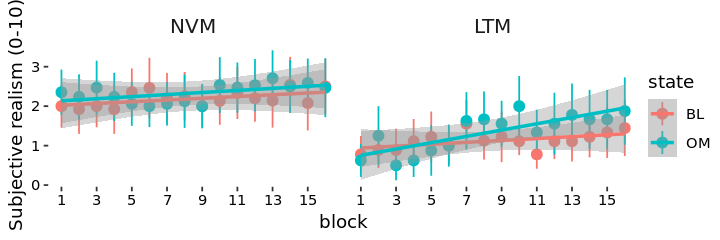

In [367]:
ggplot(create_run.state(df.scales),
       aes(x = (run.state), y = subjreal, color = state)) +
facet_grid(. ~ group) +
stat_summary(fun.data = mean_se) +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Subjective realism (0-10)") -> g

options(repr.plot.width=6, repr.plot.height=2)
g

### By percept

Automatically converting the following non-factors to factors: run

Joining, by = c("percept", "run")


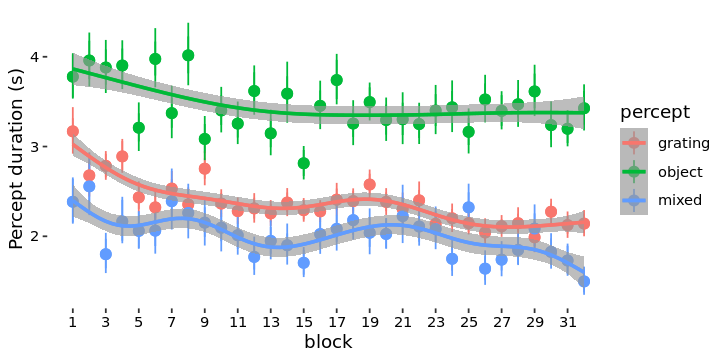

In [792]:
options(repr.plot.width=6, repr.plot.height=3)

df.plot.M <- df.mu %>%
    mutate(run==lead(run)) %>% 
    group_by(id,percept,run) %>% summarise(log_dur = mean(log_dur, na.rm=T)) %>% 
    group_by(percept,run) %>% summarise(log_dur = mean(log_dur, na.rm=T))
     
df.plot.SE <- summarySEwithin(data = df.mu %>% mutate(run==lead(run)), measurevar = "log_dur",
                              idvar = "id", withinvars = c("percept","run"), betweenvars = "group", na.rm=T) %>% 
        mutate(run = as.numeric(run))

df.plot <- left_join(df.plot.SE %>% select(-any_of("log_dur")), df.plot.M)


ggplot(df.plot,
       aes(x = run, y = exp(log_dur), ymin = exp(log_dur-se), ymax = exp(log_dur+se), color=percept)) +
#facet_grid(. ~ group) +
geom_pointrange() +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "Percept duration (s)")

### By image

In [495]:
create_run.img <- function(df) {
    left_join(df, 
              df %>% 
                select(id,group,img,run) %>% distinct() %>% 
                group_by(id,group,img) %>% mutate(run.img = row_number()) %>% 
                arrange(id,run) %>% group_by(id,group) %>% mutate(img.repeat = (img == lag(img))) %>% 
                filter(run.img <= 16)) %>% 
        return()
}

create_run.img(df.measures)

Joining, by = c("group", "id", "run", "img")


group id state run img    aff  percept dur      alpha   mu      run.img
1     LTM   76 BL    1   hammer low  object  5.61300  2.55160 1.6893  1      
2     LTM   76 BL    1   hammer low  grating 3.58970  1.73020 1.9897  1      
3     LTM   76 BL    1   hammer low  mixed   0.91792       NA     NA  1      
4     LTM   76 BL    1   hammer low  object  2.79280  1.18780 1.6153  1      
5     LTM   76 BL    1   hammer low  grating 3.69510  2.12130 2.6921  1      
6     LTM   76 BL    1   hammer low  object  1.04680       NA     NA  1      
7     LTM   76 BL    1   hammer low  mixed   1.32020       NA     NA  1      
8     LTM   76 BL    1   hammer low  object  2.96470  1.31140 2.4088  1      
9     LTM   76 BL    1   hammer low  mixed   0.60935       NA     NA  1      
10    LTM   76 BL    1   hammer low  grating 3.82010  1.54150 2.3506  1      
11    LTM   76 BL    1   hammer low  object  1.50770       NA     NA  1      
12    LTM   76 BL    1   hammer low  grating 1.74990  1.09430 2.5468  1      
13    LTM   76 BL    1   hammer low  object  3.24200  1.13050 1.7748  1      
14    LTM   76 BL    1   hammer low  grating 4.16000  1.75190 2.6306  1      
15    LTM   76 BL    1   hammer low  object  4.49590  1.32020 1.4900  1      
16    LTM   76 BL    1   hammer low  mixed   0.65231       NA     NA  1      
17    LTM   76 BL    1   hammer low  grating 1.41010       NA     NA  1      
18    LTM   76 BL    1   hammer low  object  4.39430  1.44310 1.9732  1      
19    LTM   76 BL    1   hammer low  grating 7.00750  2.49060 1.9299  1      
20    LTM   76 BL    1   hammer low  object  3.89430  1.38270 1.2696  1      
21    LTM   76 BL    1   hammer low  mixed   0.61716       NA     NA  1      
22    LTM   76 BL    1   hammer low  grating 1.66790  0.70476 2.8302  1      
23    LTM   76 BL    1   hammer low  mixed   0.67965       NA     NA  1      
24    LTM   76 BL    1   hammer low  grating 1.21480       NA     NA  1      
25    LTM   76 BL    1   hammer low  object  1.39060       NA     NA  1      
26    LTM   76 BL    1   hammer low  grating 3.15220  1.48410 2.0251  1      
27    LTM   76 BL    1   hammer low  object  1.80460  1.74930 1.8608  1      
28    LTM   76 BL    1   hammer low  grating 2.14050  2.04540 2.9391  1      
29    LTM   76 BL    1   hammer low  object  1.46480       NA     NA  1      
30    LTM   76 BL    1   hammer low  grating 1.57020       NA     NA  1      
⋮     ⋮     ⋮  ⋮     ⋮   ⋮      ⋮    ⋮       ⋮        ⋮       ⋮       ⋮      
25046 NVM   82 OM    31  teapot low  object   1.87500  3.2483  6.2518 16     
25047 NVM   82 OM    31  teapot low  mixed    1.42970      NA      NA 16     
25048 NVM   82 OM    31  teapot low  object   2.25780  4.5252  5.1805 16     
25049 NVM   82 OM    31  teapot low  grating  0.92188      NA      NA 16     
25050 NVM   82 OM    31  teapot low  object   6.76560  5.9951  7.0043 16     
25051 NVM   82 OM    31  teapot low  grating  1.84770  1.8658  3.8882 16     
25052 NVM   82 OM    31  teapot low  object   4.95310  4.3156  4.4094 16     
25053 NVM   82 OM    32  hammer high object   7.65620  5.2269  5.6161 16     
25054 NVM   82 OM    32  hammer high grating  1.87500  5.6871  4.0976 16     
25055 NVM   82 OM    32  hammer high object   4.95700  5.3819  9.2188 16     
25056 NVM   82 OM    32  hammer high grating  2.12500  4.3298 11.1110 16     
25057 NVM   82 OM    32  hammer high object   7.10550  8.1883 12.7010 16     
25058 NVM   82 OM    32  hammer high mixed    2.90230  3.7514  4.9770 16     
25059 NVM   82 OM    32  hammer high object   1.36720      NA      NA 16     
25060 NVM   82 OM    32  hammer high grating  1.63280  6.4690  2.9209 16     
25061 NVM   82 OM    32  hammer high object   8.07030  4.1237  6.4727 16     
25062 NVM   82 OM    32  hammer high grating  2.33200  7.2548  8.2170 16     
25063 NVM   82 OM    32  hammer high object   1.74220 10.1190  3.8446 16     
25064 NVM   82 OM    32  hammer high mixed    1.93750  5.1312  6.3629 16     
25065 NVM   82 OM    32  ham

Joining, by = c("group", "id", "run", "img")
Warning message:
“Removed 158 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 158 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 158 rows containing non-finite values (stat_smooth).”
Joining, by = c("group", "id", "run", "img")
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”


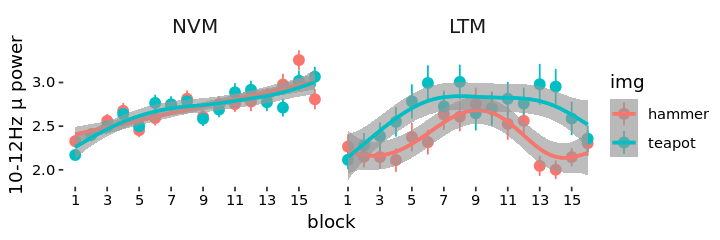

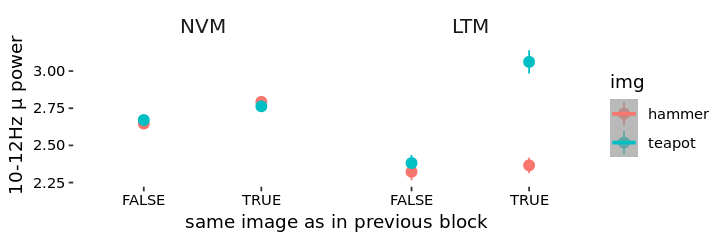

In [403]:
ggplot(create_run.img(df.mu),
       aes(x = run.img, y = exp(log_mu), color = img)) +
facet_grid(. ~ group) +
stat_summary(fun.data = mean_se) +
scale_x_continuous(breaks = seq(1,32,2)) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "block", y = "10-12Hz µ power") -> g1

options(repr.plot.width=6, repr.plot.height=2)
g1


ggplot(create_run.img(df.mu) %>% filter(!is.na(img.repeat)),
       aes(x = img.repeat, y = exp(log_mu), color = img)) +
facet_grid(. ~ group) +
stat_summary(fun.data = mean_se) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
geom_smooth(method = "gam", formula = (y ~ s(x, bs = 'tp'))) +
labs(x = "same image as in previous block", y = "10-12Hz µ power") -> g2

options(repr.plot.width=6, repr.plot.height=2)
g2